# Import and settings

In [25]:
import torch #基本モジュール
from torch.autograd import Variable #自動微分用
import torch.nn as nn #ネットワーク構築用
import torch.optim as optim #最適化関数
import torch.nn.functional as F #ネットワーク用の様々な関数
import torch.utils.data #データセット読み込み関連
import torchvision #画像関連
from torchvision import datasets, models, transforms #画像用データセット諸々

import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, StratifiedKFold

from tqdm import tqdm

import logging
import logzero
from logzero import logger


# examination settings
batch_size = 128
test_batch_size = batch_size * 4
momentum = 0.9
seed = 2017
num_workers = 2
use_gpu = False

# set seed for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

# logger setting
LOG_FORMAT = '[%(asctime)s %(levelname)s] %(message)s'
logzero.loglevel(logging.INFO)
logzero.formatter(logging.Formatter(LOG_FORMAT))

# Prepare data

In [26]:
train_dataset = datasets.MNIST('./data/MNIST/train/', download=True, train=True)
test_dataset = datasets.MNIST('./data/MNIST/test/', download=True, train=False)

train_data = train_dataset.train_data.numpy()
test_data = test_dataset.test_data.numpy()
train_labels = train_dataset.train_labels.numpy()
test_labels = test_dataset.test_labels.numpy()

In [27]:
print(len(train_labels), len(test_labels))

60000 10000


## Change the ratio train/test
train:val:test を 1000:1000:68000に設定。各クラスのサンプル数は均一に。testセットは実際に教師なし学習に用いることは想定しづらいので、現実のタスクや論文に書く時はunlabeledデータとして説明すれば良い。その場合はtestセット内で更に unlabeled/holdout に分ける必要がある。
交差検証は行わない。

pseudo label実験に対してはtestデータはunlabeledデータ及び最終評価用のデータとして使われる。valは学習中の精度監視用。

In [28]:
n_train = 1000
n_val = 1000
n_test = 10000
n_unlabeled = 58000

X_train = np.empty(shape=(0, 28, 28))
y_train = np.empty(shape=(0,))
X_val = np.empty(shape=(0, 28, 28))
y_val = np.empty(shape=(0,))
X_test = np.empty(shape=(0, 28, 28))
y_test = np.empty(shape=(0,))

for i in range(10):
    idx_train = np.argwhere(train_labels == i)[:(n_train//10)].squeeze()
    idx_val = np.argwhere(train_labels == i)[(n_train//10):((n_train+n_val)//10)].squeeze()
    idx_test = np.argwhere(train_labels == i)[((n_train+n_val)//10):].squeeze()
    
    X_train = np.concatenate([X_train, train_data[idx_train]], axis=0)
    y_train = np.concatenate([y_train, train_labels[idx_train]], axis=0)
    X_val = np.concatenate([X_val, train_data[idx_val]], axis=0)
    y_val = np.concatenate([y_val, train_labels[idx_val]], axis=0)
    X_test = np.concatenate([X_test, train_data[idx_test]], axis=0)
    y_test = np.concatenate([y_test, train_labels[idx_test]], axis=0)
    
X_test = np.concatenate([X_test, test_data], axis=0)
y_test = np.concatenate([y_test, test_labels], axis=0)

# treat as image
X_train = np.expand_dims(X_train, -1)
X_val = np.expand_dims(X_val, -1)
X_test = np.expand_dims(X_test, -1)

# one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(1000, 28, 28, 1) (1000, 10) (1000, 28, 28, 1) (1000, 10) (68000, 28, 28, 1) (68000, 10)


## Prepare Pseudo Label

testデータをtest/unlabeledに分ける。
比率は10000:58000とする。（元々のMNISTの提供時点でのtest splitを用いる）

In [29]:
y_pseudo = np.load('./save/pseudo_label_supervised.npy')

random_idx = np.random.permutation(n_unlabeled)

X_unlabeled1 = X_test[random_idx[:n_unlabeled//2]]
y_unlabeled1 = y_test[random_idx[:n_unlabeled//2]]
X_unlabeled2 = X_test[random_idx[n_unlabeled//2:]]
y_unlabeled2 = y_test[random_idx[n_unlabeled//2:]]
X_test = X_test[n_unlabeled:]
y_test = y_test[n_unlabeled:]

print(
    X_unlabeled1.shape, y_unlabeled1.shape,
    X_unlabeled2.shape, y_unlabeled2.shape,
    X_test.shape, y_test.shape
)

(29000, 28, 28, 1) (29000, 10) (29000, 28, 28, 1) (29000, 10) (10000, 28, 28, 1) (10000, 10)


# Define a network

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.bn1(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.bn2(self.conv2(x)), 2))
        x = F.adaptive_max_pool2d(x, output_size=1)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.log_softmax(x)
        return x

# Define Dataset, DataLoader

In [31]:
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        img = self.X[index]
        img = self.transform(img)
        target = torch.Tensor(self.y[index].astype(float))
        return img, target
    
    def __len__(self):
        return len(self.X)


class MNISTDatasetForPseudoLabeling(torch.utils.data.Dataset):
    def __init__(self, X_train, y_train, X_dash, y_dash, ratio_pl, hard, transform):
        self.X_train = X_train
        self.y_train = y_train
        self.X_dash = X_dash
        self.y_dash = y_dash
        self.ratio_pl = ratio_pl
        self.hard = hard
        self.transform = transform
        
    def __getitem__(self, index):
        if index < len(self.X_train):
            img = self.X_train[index]
            target = torch.Tensor(self.y_train[index].astype(float))
        else:
            index = np.random.randint(0, len(self.X_dash))
            img = self.X_dash[index]
            if self.hard:
                hard_label = int(np.argmax(self.y_dash[index]))
                zeros = np.zeros_like(self.y_dash[index])
                zeros[hard_label] = 1.0
                target = torch.Tensor(zeros)
            else:
                target = torch.Tensor(self.y_dash[index].astype(float))
        
        img = self.transform(img)
        return img, target
    
    def __len__(self):
        return int(len(self.X_train) * (1 + ratio_pl))

# Define TrainingTracker

In [23]:
class TrainingTracker(object):
    def __init__(self):
        self.epoch = 0
        self.history = {
            'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []
        }
        self.reset()
        
    def reset(self):
        self.train_acc = 0
        self.train_loss = 0
        self.val_acc = 0
        self.val_loss = 0
        self.train_count = 0
        self.val_count = 0

    def update(self, train, acc, loss, n):
        if train:
            acc_sum = self.train_acc * self.train_count + acc * n
            loss_sum = self.train_loss * self.train_count + loss * n
            self.train_count += n
            self.train_acc = acc_sum / self.train_count
            self.train_loss = loss_sum / self.train_count
        else:
            acc_sum = self.val_acc * self.val_count + acc * n
            loss_sum = self.val_loss * self.val_count + loss * n
            self.val_count += n
            self.val_acc = acc_sum / self.val_count
            self.val_loss = loss_sum / self.val_count

    def plot_history(self):
        plt.plot(self.history['train_acc'])
        plt.plot(self.history['val_acc'])
        plt.title('model accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(['train_acc', 'val_acc'], loc='lower right')
        plt.show()

        plt.plot(self.history['train_loss'])
        plt.plot(self.history['val_loss'])
        plt.title('model loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['train_loss', 'val_loss'], loc='lower right')
        plt.show()

# Define train, validate, test function

In [24]:
def _train(model, data_loader, criterion, optimizer, tracker):
    model.train()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=True, acc=acc, loss=loss.data[0], n=len(X))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    logger.info(
        'Epoch: {tracker.epoch} | '
        'TrainAcc: {tracker.train_acc:.4f} | '
        'TrainLoss: {tracker.train_loss:.4f}'.format(
            tracker=tracker)
    )
    tracker.history['train_acc'].append(tracker.train_acc)
    tracker.history['train_loss'] .append(tracker.train_loss)
    tracker.reset()

def _validate(model, data_loader, criterion, tracker):
    model.eval()
    for i, (X, y) in enumerate(data_loader):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc = pred.eq(answer).sum() / len(X)
        tracker.update(train=False, acc=acc, loss=loss.data[0], n=len(X))

    logger.info(
        'Epoch: {tracker.epoch} | '
        'ValAcc: {tracker.val_acc:.4f} | '
        'ValLoss: {tracker.val_loss:.4f} \n'.format(
            tracker=tracker)
    )
    tracker.history['val_acc'].append(tracker.val_acc)
    tracker.history['val_loss'].append(tracker.val_loss)
    tracker.reset()
    
def _test(model, data_loader, criterion, unlabeled=False, make_pl=False):
    model.eval()
    
    if make_pl:
        pseudo_label = np.empty((0, 10))
    
    acc_sum = 0
    loss_sum = 0
    n_sample = 0
    for i, (X, y) in tqdm(enumerate(data_loader), total=len(data_loader)):
        if use_gpu:
            X, y = X.cuda(), y.cuda()
        X, y = Variable(X), Variable(y)
        
        output = model(X)
        loss = criterion(output, y)
        pred = output.data.max(1)[1]
        answer = y.data.max(1)[1]
        acc_sum += pred.eq(answer).sum()
        loss_sum += loss.data[0] * X.size(0)
        n_sample += X.size(0)
        if make_pl:
            pseudo_label = np.concatenate([pseudo_label, output.data.numpy()], axis=0)
    
    if make_pl:
        pseudo_label = np.exp(pseudo_label)
        np.save('./save/pseudo_label_{}.npy'.format(ex_name), pseudo_label)
        
    acc = acc_sum / n_sample
    loss = loss_sum / n_sample
    
    return acc, loss

# Experiments

##  Cross Pseudo Labeling

[2017-12-02 23:47:51,188 INFO] Epoch: 0 | TrainAcc: 0.1650 | TrainLoss: 0.2293
[2017-12-02 23:47:51,543 INFO] Epoch: 0 | ValAcc: 0.2420 | ValLoss: 0.2165 

[2017-12-02 23:47:52,802 INFO] Epoch: 1 | TrainAcc: 0.3375 | TrainLoss: 0.1921
[2017-12-02 23:47:53,148 INFO] Epoch: 1 | ValAcc: 0.4400 | ValLoss: 0.1682 

[2017-12-02 23:47:54,416 INFO] Epoch: 2 | TrainAcc: 0.4840 | TrainLoss: 0.1498
[2017-12-02 23:47:54,770 INFO] Epoch: 2 | ValAcc: 0.4760 | ValLoss: 0.1361 

[2017-12-02 23:47:56,089 INFO] Epoch: 3 | TrainAcc: 0.5275 | TrainLoss: 0.1363
[2017-12-02 23:47:56,441 INFO] Epoch: 3 | ValAcc: 0.5550 | ValLoss: 0.1506 

[2017-12-02 23:47:57,923 INFO] Epoch: 4 | TrainAcc: 0.6725 | TrainLoss: 0.0998
[2017-12-02 23:47:58,277 INFO] Epoch: 4 | ValAcc: 0.7160 | ValLoss: 0.0929 

[2017-12-02 23:47:59,541 INFO] Epoch: 5 | TrainAcc: 0.7990 | TrainLoss: 0.0634
[2017-12-02 23:47:59,898 INFO] Epoch: 5 | ValAcc: 0.7680 | ValLoss: 0.0690 

[2017-12-02 23:48:01,341 INFO] Epoch: 6 | TrainAcc: 0.8415 | Tra

[2017-12-02 23:49:24,300 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:49:24,665 INFO] Epoch: 52 | ValAcc: 0.8960 | ValLoss: 0.0404 

[2017-12-02 23:49:25,929 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-02 23:49:26,278 INFO] Epoch: 53 | ValAcc: 0.8990 | ValLoss: 0.0403 

[2017-12-02 23:49:27,546 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:49:27,921 INFO] Epoch: 54 | ValAcc: 0.8990 | ValLoss: 0.0404 

[2017-12-02 23:49:29,230 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:49:29,592 INFO] Epoch: 55 | ValAcc: 0.9000 | ValLoss: 0.0404 

[2017-12-02 23:49:30,848 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:49:31,208 INFO] Epoch: 56 | ValAcc: 0.8980 | ValLoss: 0.0407 

[2017-12-02 23:49:32,483 INFO] Epoch: 57 | TrainAcc: 0.9995 | TrainLoss: 0.0002
[2017-12-02 23:49:32,834 INFO] Epoch: 57 | ValAcc: 0.8990 | ValLoss: 0.0408 

[2017-12-02 23:49:34,090 INFO] Epoch: 58 | TrainAcc:

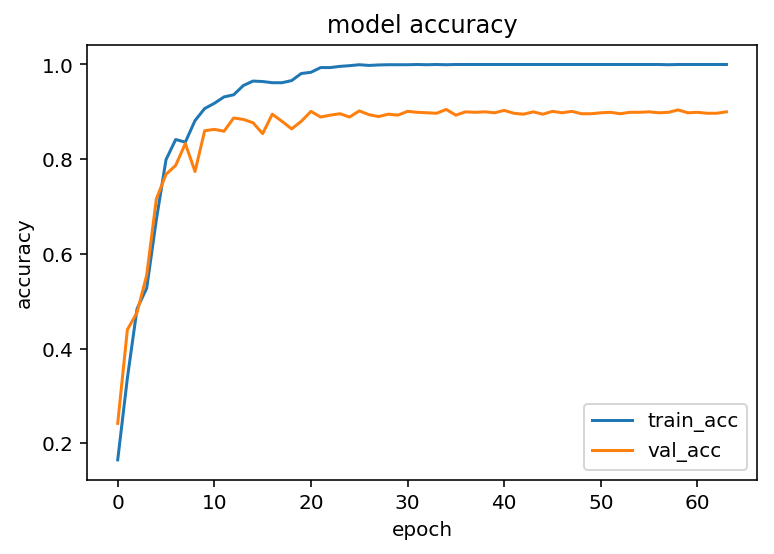

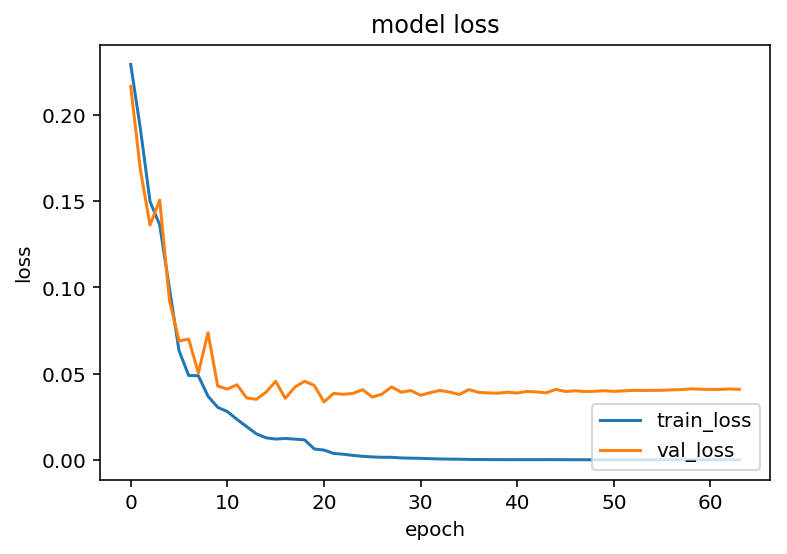

100%|██████████| 20/20 [00:02<00:00,  8.28it/s]
[2017-12-02 23:49:46,051 INFO] TestAcc: 0.9123 | TestLoss: 0.0332 
100%|██████████| 114/114 [00:12<00:00,  8.81it/s]
[2017-12-02 23:49:59,037 INFO] UnlabeledAcc: 0.9053 | UnlabeledLoss: 0.0370 
[2017-12-02 23:50:00,339 INFO] Epoch: 0 | TrainAcc: 0.2035 | TrainLoss: 0.2325
[2017-12-02 23:50:00,703 INFO] Epoch: 0 | ValAcc: 0.1640 | ValLoss: 0.2162 

[2017-12-02 23:50:02,031 INFO] Epoch: 1 | TrainAcc: 0.4015 | TrainLoss: 0.1779
[2017-12-02 23:50:02,395 INFO] Epoch: 1 | ValAcc: 0.5010 | ValLoss: 0.1528 

[2017-12-02 23:50:03,679 INFO] Epoch: 2 | TrainAcc: 0.6075 | TrainLoss: 0.1160
[2017-12-02 23:50:04,044 INFO] Epoch: 2 | ValAcc: 0.7410 | ValLoss: 0.0881 

[2017-12-02 23:50:05,378 INFO] Epoch: 3 | TrainAcc: 0.7535 | TrainLoss: 0.0761
[2017-12-02 23:50:05,740 INFO] Epoch: 3 | ValAcc: 0.7920 | ValLoss: 0.0641 

[2017-12-02 23:50:07,020 INFO] Epoch: 4 | TrainAcc: 0.8095 | TrainLoss: 0.0584
[2017-12-02 23:50:07,377 INFO] Epoch: 4 | ValAcc: 0.806

[2017-12-02 23:51:27,479 INFO] Epoch: 50 | ValAcc: 0.9050 | ValLoss: 0.0382 

[2017-12-02 23:51:28,791 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:51:29,204 INFO] Epoch: 51 | ValAcc: 0.9040 | ValLoss: 0.0383 

[2017-12-02 23:51:30,502 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:51:30,839 INFO] Epoch: 52 | ValAcc: 0.9060 | ValLoss: 0.0385 

[2017-12-02 23:51:32,229 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:51:32,568 INFO] Epoch: 53 | ValAcc: 0.9040 | ValLoss: 0.0390 

[2017-12-02 23:51:33,798 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:51:34,150 INFO] Epoch: 54 | ValAcc: 0.9060 | ValLoss: 0.0387 

[2017-12-02 23:51:35,386 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:51:35,721 INFO] Epoch: 55 | ValAcc: 0.9060 | ValLoss: 0.0387 

[2017-12-02 23:51:36,935 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:51:37,264 INFO] Epoch: 56 | ValAcc: 0

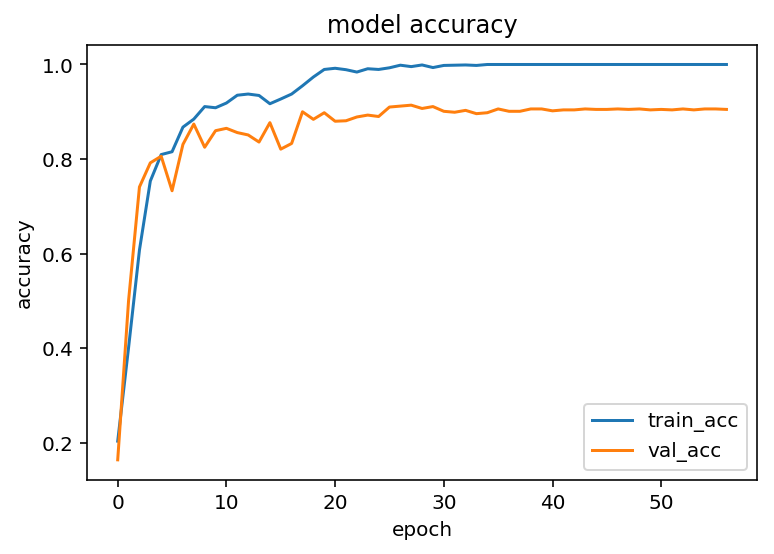

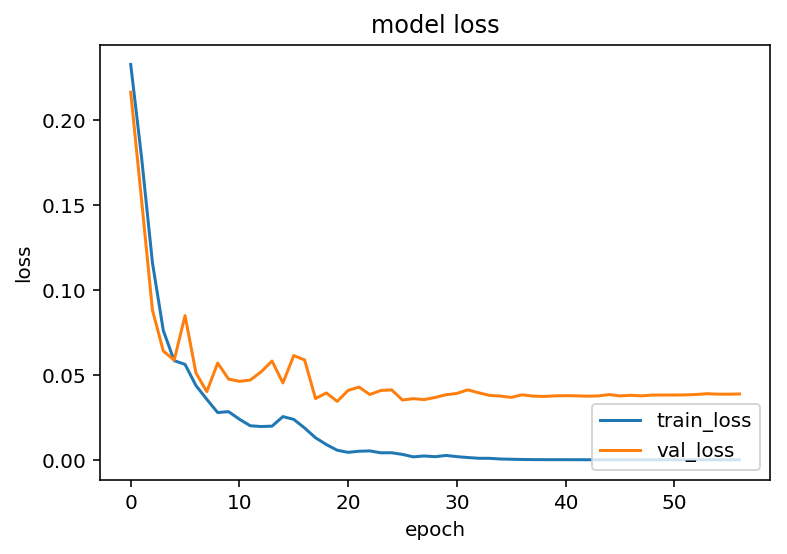

100%|██████████| 20/20 [00:02<00:00,  9.45it/s]
[2017-12-02 23:51:39,661 INFO] TestAcc: 0.9105 | TestLoss: 0.0336 
100%|██████████| 114/114 [00:11<00:00,  9.98it/s]
[2017-12-02 23:51:51,123 INFO] UnlabeledAcc: 0.9044 | UnlabeledLoss: 0.0358 
[2017-12-02 23:51:52,290 INFO] Epoch: 0 | TrainAcc: 0.1980 | TrainLoss: 0.2288
[2017-12-02 23:51:52,637 INFO] Epoch: 0 | ValAcc: 0.2390 | ValLoss: 0.2150 

[2017-12-02 23:51:53,851 INFO] Epoch: 1 | TrainAcc: 0.4635 | TrainLoss: 0.1668
[2017-12-02 23:51:54,183 INFO] Epoch: 1 | ValAcc: 0.5280 | ValLoss: 0.1440 

[2017-12-02 23:51:55,407 INFO] Epoch: 2 | TrainAcc: 0.6320 | TrainLoss: 0.1111
[2017-12-02 23:51:55,746 INFO] Epoch: 2 | ValAcc: 0.4600 | ValLoss: 0.1504 

[2017-12-02 23:51:56,970 INFO] Epoch: 3 | TrainAcc: 0.6925 | TrainLoss: 0.0905
[2017-12-02 23:51:57,309 INFO] Epoch: 3 | ValAcc: 0.7060 | ValLoss: 0.0821 

[2017-12-02 23:51:58,517 INFO] Epoch: 4 | TrainAcc: 0.8000 | TrainLoss: 0.0598
[2017-12-02 23:51:58,847 INFO] Epoch: 4 | ValAcc: 0.779

[2017-12-02 23:53:10,546 INFO] Epoch: 50 | ValAcc: 0.9070 | ValLoss: 0.0356 

[2017-12-02 23:53:11,793 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:53:12,144 INFO] Epoch: 51 | ValAcc: 0.9080 | ValLoss: 0.0355 

[2017-12-02 23:53:13,367 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:53:13,694 INFO] Epoch: 52 | ValAcc: 0.9060 | ValLoss: 0.0357 

[2017-12-02 23:53:14,895 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:53:15,237 INFO] Epoch: 53 | ValAcc: 0.9100 | ValLoss: 0.0359 

[2017-12-02 23:53:16,440 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:53:16,795 INFO] Epoch: 54 | ValAcc: 0.9090 | ValLoss: 0.0360 

[2017-12-02 23:53:18,006 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:53:18,351 INFO] Epoch: 55 | ValAcc: 0.9090 | ValLoss: 0.0356 

[2017-12-02 23:53:19,569 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:53:19,924 INFO] Epoch: 56 | ValAcc: 0

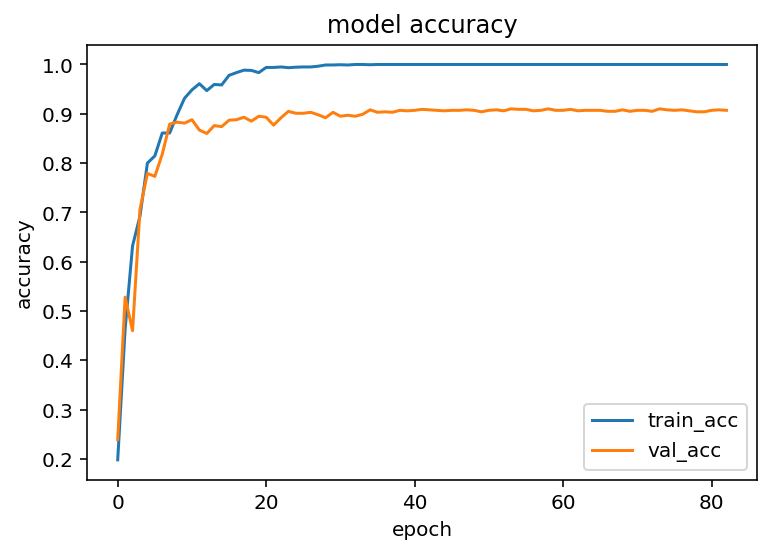

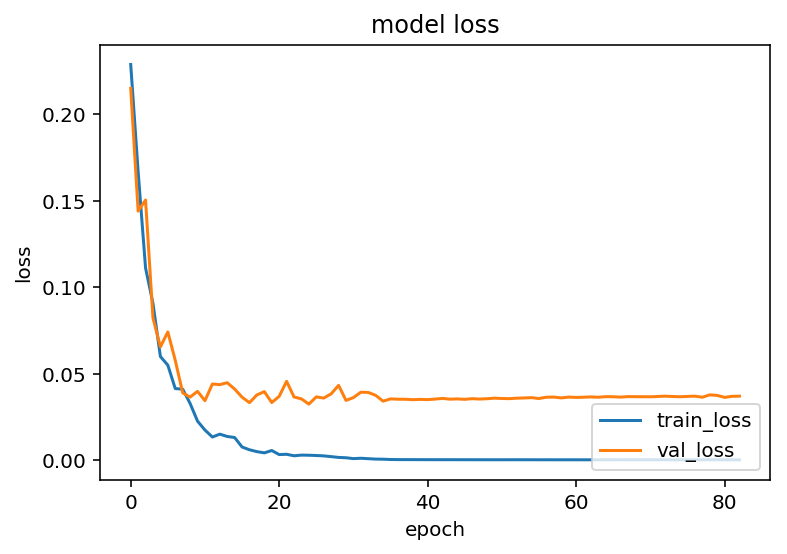

100%|██████████| 20/20 [00:02<00:00,  9.28it/s]
[2017-12-02 23:54:04,403 INFO] TestAcc: 0.9232 | TestLoss: 0.0311 
100%|██████████| 114/114 [00:11<00:00, 10.05it/s]
[2017-12-02 23:54:15,788 INFO] UnlabeledAcc: 0.9149 | UnlabeledLoss: 0.0359 
[2017-12-02 23:54:17,015 INFO] Epoch: 0 | TrainAcc: 0.1605 | TrainLoss: 0.2360
[2017-12-02 23:54:17,362 INFO] Epoch: 0 | ValAcc: 0.2440 | ValLoss: 0.2226 

[2017-12-02 23:54:18,580 INFO] Epoch: 1 | TrainAcc: 0.2825 | TrainLoss: 0.2002
[2017-12-02 23:54:18,917 INFO] Epoch: 1 | ValAcc: 0.3730 | ValLoss: 0.1842 

[2017-12-02 23:54:20,123 INFO] Epoch: 2 | TrainAcc: 0.5340 | TrainLoss: 0.1494
[2017-12-02 23:54:20,462 INFO] Epoch: 2 | ValAcc: 0.4760 | ValLoss: 0.1566 

[2017-12-02 23:54:21,646 INFO] Epoch: 3 | TrainAcc: 0.6320 | TrainLoss: 0.1098
[2017-12-02 23:54:21,981 INFO] Epoch: 3 | ValAcc: 0.5870 | ValLoss: 0.1175 

[2017-12-02 23:54:23,203 INFO] Epoch: 4 | TrainAcc: 0.7465 | TrainLoss: 0.0795
[2017-12-02 23:54:23,604 INFO] Epoch: 4 | ValAcc: 0.694

[2017-12-02 23:55:37,524 INFO] Epoch: 50 | ValAcc: 0.9050 | ValLoss: 0.0452 

[2017-12-02 23:55:38,822 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:55:39,172 INFO] Epoch: 51 | ValAcc: 0.8990 | ValLoss: 0.0453 

[2017-12-02 23:55:40,560 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:55:40,976 INFO] Epoch: 52 | ValAcc: 0.9010 | ValLoss: 0.0454 

[2017-12-02 23:55:42,280 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:55:42,635 INFO] Epoch: 53 | ValAcc: 0.8980 | ValLoss: 0.0457 

[2017-12-02 23:55:43,886 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:55:44,240 INFO] Epoch: 54 | ValAcc: 0.9030 | ValLoss: 0.0453 

[2017-12-02 23:55:45,614 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:55:46,046 INFO] Epoch: 55 | ValAcc: 0.9010 | ValLoss: 0.0454 

[2017-12-02 23:55:47,345 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:55:47,683 INFO] Epoch: 56 | ValAcc: 0

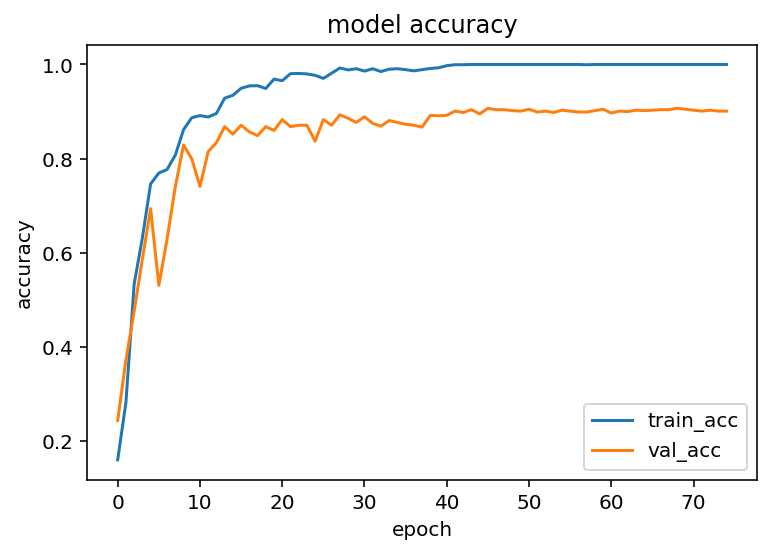

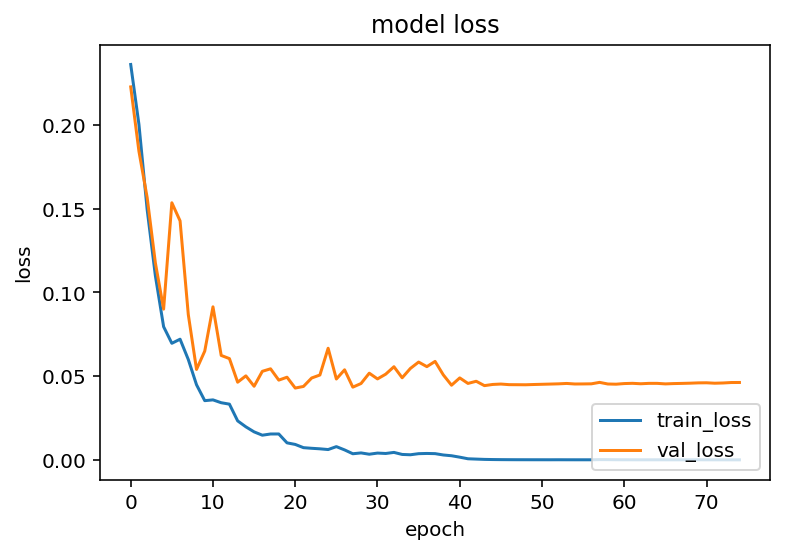

100%|██████████| 20/20 [00:02<00:00,  8.15it/s]
[2017-12-02 23:56:20,500 INFO] TestAcc: 0.9127 | TestLoss: 0.0352 
100%|██████████| 114/114 [00:11<00:00,  9.54it/s]
[2017-12-02 23:56:32,505 INFO] UnlabeledAcc: 0.9062 | UnlabeledLoss: 0.0400 
[2017-12-02 23:56:33,705 INFO] Epoch: 0 | TrainAcc: 0.1865 | TrainLoss: 0.2279
[2017-12-02 23:56:34,057 INFO] Epoch: 0 | ValAcc: 0.2900 | ValLoss: 0.2145 

[2017-12-02 23:56:35,328 INFO] Epoch: 1 | TrainAcc: 0.3675 | TrainLoss: 0.1811
[2017-12-02 23:56:35,664 INFO] Epoch: 1 | ValAcc: 0.4350 | ValLoss: 0.1602 

[2017-12-02 23:56:36,903 INFO] Epoch: 2 | TrainAcc: 0.5600 | TrainLoss: 0.1287
[2017-12-02 23:56:37,243 INFO] Epoch: 2 | ValAcc: 0.5110 | ValLoss: 0.1377 

[2017-12-02 23:56:38,486 INFO] Epoch: 3 | TrainAcc: 0.6585 | TrainLoss: 0.1004
[2017-12-02 23:56:38,825 INFO] Epoch: 3 | ValAcc: 0.4120 | ValLoss: 0.1748 

[2017-12-02 23:56:40,055 INFO] Epoch: 4 | TrainAcc: 0.7605 | TrainLoss: 0.0731
[2017-12-02 23:56:40,406 INFO] Epoch: 4 | ValAcc: 0.745

[2017-12-02 23:57:54,800 INFO] Epoch: 50 | ValAcc: 0.9100 | ValLoss: 0.0378 

[2017-12-02 23:57:56,078 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:57:56,423 INFO] Epoch: 51 | ValAcc: 0.9090 | ValLoss: 0.0377 

[2017-12-02 23:57:57,686 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:57:58,040 INFO] Epoch: 52 | ValAcc: 0.9110 | ValLoss: 0.0374 

[2017-12-02 23:57:59,283 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:57:59,626 INFO] Epoch: 53 | ValAcc: 0.9080 | ValLoss: 0.0378 

[2017-12-02 23:58:00,845 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:58:01,181 INFO] Epoch: 54 | ValAcc: 0.9090 | ValLoss: 0.0377 

[2017-12-02 23:58:02,608 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:58:03,013 INFO] Epoch: 55 | ValAcc: 0.9100 | ValLoss: 0.0381 

[2017-12-02 23:58:04,452 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-02 23:58:04,823 INFO] Epoch: 56 | ValAcc: 0

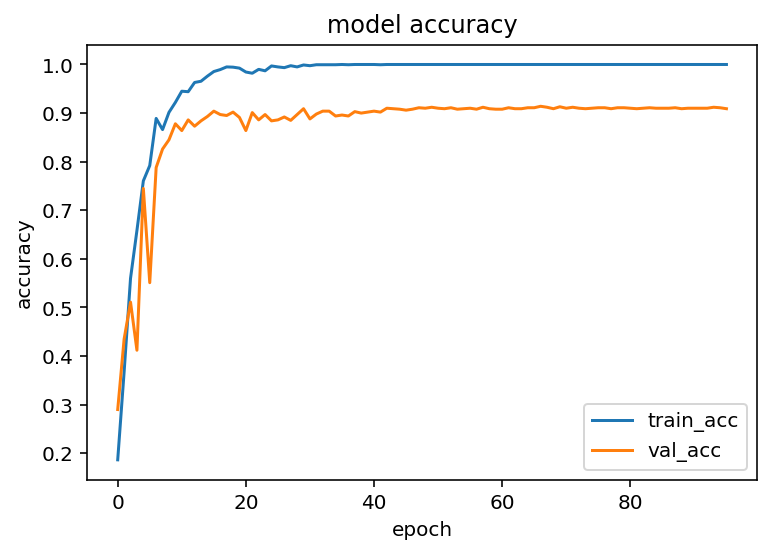

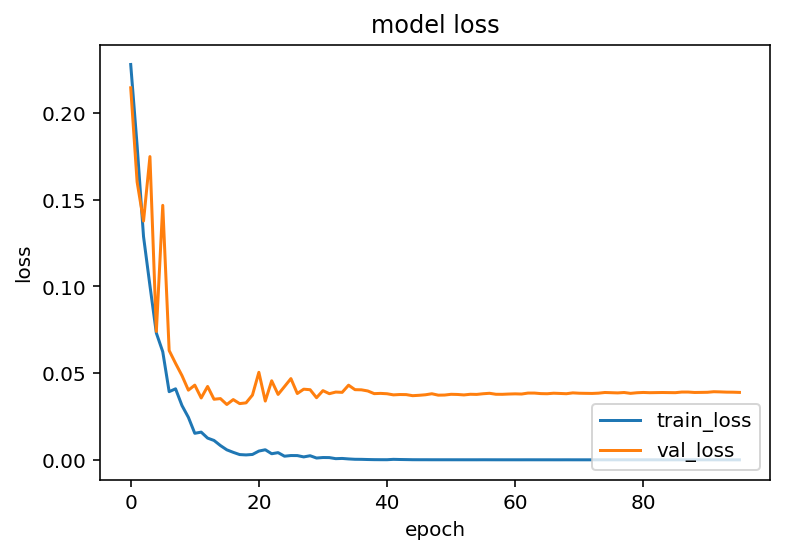

100%|██████████| 20/20 [00:02<00:00,  8.48it/s]
[2017-12-02 23:59:16,186 INFO] TestAcc: 0.9272 | TestLoss: 0.0318 
100%|██████████| 114/114 [00:12<00:00,  9.49it/s]
[2017-12-02 23:59:28,244 INFO] UnlabeledAcc: 0.9196 | UnlabeledLoss: 0.0347 
[2017-12-02 23:59:29,622 INFO] Epoch: 0 | TrainAcc: 0.2070 | TrainLoss: 0.2277
[2017-12-02 23:59:29,979 INFO] Epoch: 0 | ValAcc: 0.3480 | ValLoss: 0.2125 

[2017-12-02 23:59:31,347 INFO] Epoch: 1 | TrainAcc: 0.4800 | TrainLoss: 0.1611
[2017-12-02 23:59:31,707 INFO] Epoch: 1 | ValAcc: 0.4670 | ValLoss: 0.1470 

[2017-12-02 23:59:33,063 INFO] Epoch: 2 | TrainAcc: 0.6910 | TrainLoss: 0.0965
[2017-12-02 23:59:33,433 INFO] Epoch: 2 | ValAcc: 0.6350 | ValLoss: 0.0977 

[2017-12-02 23:59:34,773 INFO] Epoch: 3 | TrainAcc: 0.7550 | TrainLoss: 0.0732
[2017-12-02 23:59:35,123 INFO] Epoch: 3 | ValAcc: 0.7570 | ValLoss: 0.0736 

[2017-12-02 23:59:36,458 INFO] Epoch: 4 | TrainAcc: 0.8085 | TrainLoss: 0.0577
[2017-12-02 23:59:36,794 INFO] Epoch: 4 | ValAcc: 0.816

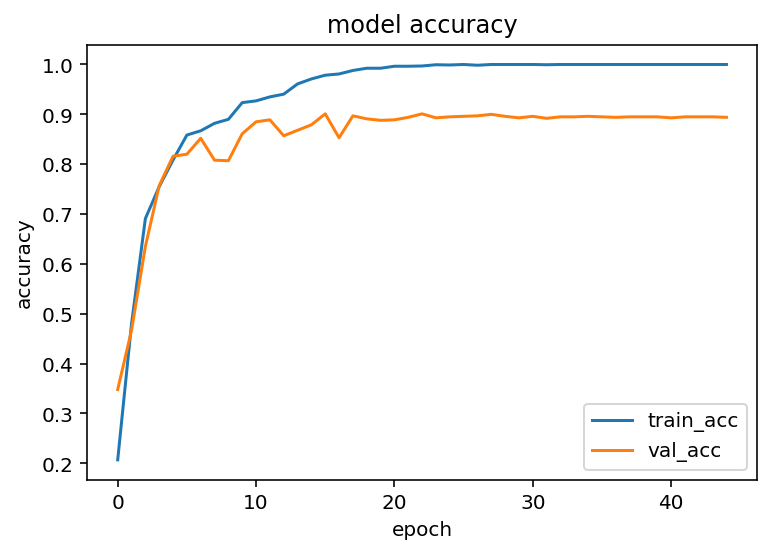

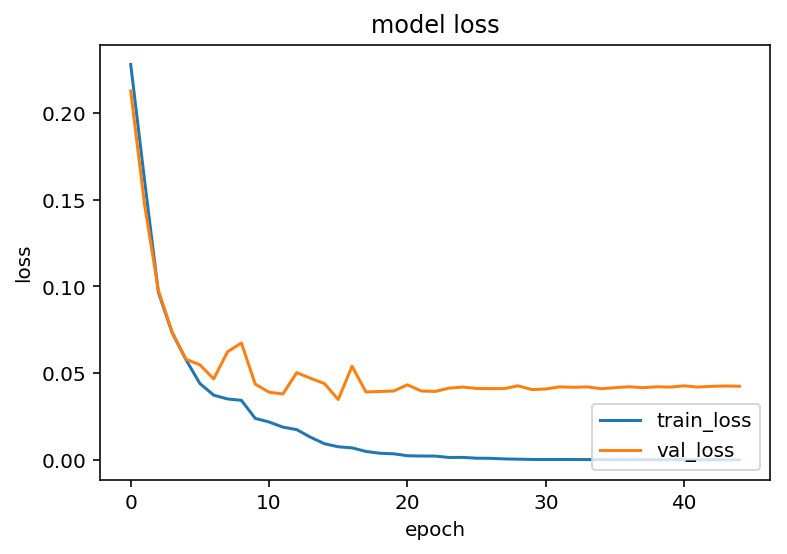

100%|██████████| 20/20 [00:02<00:00,  8.57it/s]
[2017-12-03 00:00:45,514 INFO] TestAcc: 0.9089 | TestLoss: 0.0299 
100%|██████████| 114/114 [00:13<00:00,  8.68it/s]
[2017-12-03 00:00:58,702 INFO] UnlabeledAcc: 0.9027 | UnlabeledLoss: 0.0323 
[2017-12-03 00:01:00,009 INFO] Epoch: 0 | TrainAcc: 0.2095 | TrainLoss: 0.2273
[2017-12-03 00:01:00,482 INFO] Epoch: 0 | ValAcc: 0.1780 | ValLoss: 0.2176 

[2017-12-03 00:01:01,803 INFO] Epoch: 1 | TrainAcc: 0.4340 | TrainLoss: 0.1739
[2017-12-03 00:01:02,335 INFO] Epoch: 1 | ValAcc: 0.5410 | ValLoss: 0.1559 

[2017-12-03 00:01:03,698 INFO] Epoch: 2 | TrainAcc: 0.5525 | TrainLoss: 0.1303
[2017-12-03 00:01:04,243 INFO] Epoch: 2 | ValAcc: 0.4920 | ValLoss: 0.1491 

[2017-12-03 00:01:05,466 INFO] Epoch: 3 | TrainAcc: 0.6200 | TrainLoss: 0.1102
[2017-12-03 00:01:05,951 INFO] Epoch: 3 | ValAcc: 0.6340 | ValLoss: 0.1133 

[2017-12-03 00:01:07,189 INFO] Epoch: 4 | TrainAcc: 0.7385 | TrainLoss: 0.0799
[2017-12-03 00:01:07,817 INFO] Epoch: 4 | ValAcc: 0.748

[2017-12-03 00:02:30,291 INFO] Epoch: 50 | ValAcc: 0.8800 | ValLoss: 0.0477 

[2017-12-03 00:02:31,660 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:02:32,260 INFO] Epoch: 51 | ValAcc: 0.8830 | ValLoss: 0.0479 

[2017-12-03 00:02:33,620 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:02:34,112 INFO] Epoch: 52 | ValAcc: 0.8840 | ValLoss: 0.0477 

[2017-12-03 00:02:35,353 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:02:35,809 INFO] Epoch: 53 | ValAcc: 0.8820 | ValLoss: 0.0486 

[2017-12-03 00:02:37,065 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:02:37,532 INFO] Epoch: 54 | ValAcc: 0.8830 | ValLoss: 0.0483 

[2017-12-03 00:02:38,784 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:02:39,261 INFO] Epoch: 55 | ValAcc: 0.8810 | ValLoss: 0.0485 

[2017-12-03 00:02:40,538 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:02:41,029 INFO] Epoch: 56 | ValAcc: 0

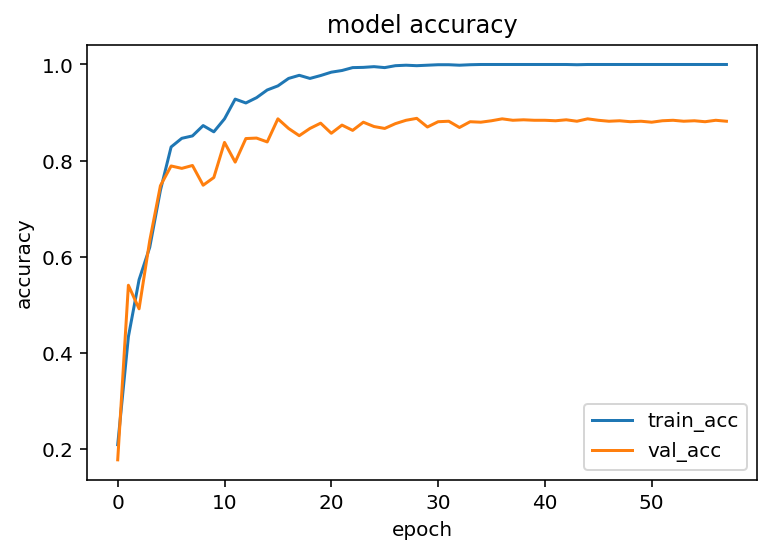

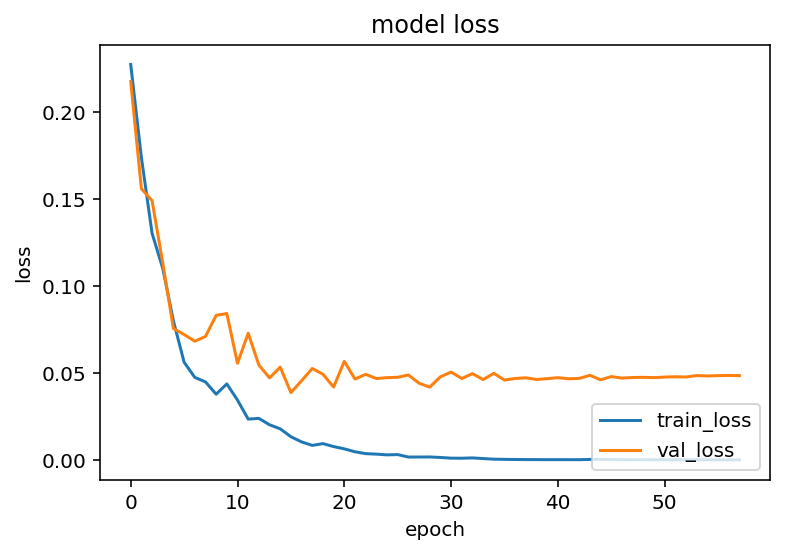

100%|██████████| 20/20 [00:02<00:00,  7.74it/s]
[2017-12-03 00:02:45,800 INFO] TestAcc: 0.9032 | TestLoss: 0.0352 
100%|██████████| 114/114 [00:13<00:00,  8.23it/s]
[2017-12-03 00:02:59,696 INFO] UnlabeledAcc: 0.8950 | UnlabeledLoss: 0.0406 
[2017-12-03 00:03:01,077 INFO] Epoch: 0 | TrainAcc: 0.1695 | TrainLoss: 0.2293
[2017-12-03 00:03:01,433 INFO] Epoch: 0 | ValAcc: 0.1900 | ValLoss: 0.2194 

[2017-12-03 00:03:02,696 INFO] Epoch: 1 | TrainAcc: 0.3965 | TrainLoss: 0.1871
[2017-12-03 00:03:03,045 INFO] Epoch: 1 | ValAcc: 0.4950 | ValLoss: 0.1662 

[2017-12-03 00:03:04,277 INFO] Epoch: 2 | TrainAcc: 0.6095 | TrainLoss: 0.1226
[2017-12-03 00:03:04,617 INFO] Epoch: 2 | ValAcc: 0.5010 | ValLoss: 0.1400 

[2017-12-03 00:03:05,839 INFO] Epoch: 3 | TrainAcc: 0.7375 | TrainLoss: 0.0810
[2017-12-03 00:03:06,178 INFO] Epoch: 3 | ValAcc: 0.7320 | ValLoss: 0.0894 

[2017-12-03 00:03:07,382 INFO] Epoch: 4 | TrainAcc: 0.8095 | TrainLoss: 0.0591
[2017-12-03 00:03:07,720 INFO] Epoch: 4 | ValAcc: 0.803

[2017-12-03 00:04:24,072 INFO] Epoch: 50 | ValAcc: 0.8950 | ValLoss: 0.0450 

[2017-12-03 00:04:25,535 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:04:26,213 INFO] Epoch: 51 | ValAcc: 0.8910 | ValLoss: 0.0457 

[2017-12-03 00:04:27,721 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:04:28,097 INFO] Epoch: 52 | ValAcc: 0.8940 | ValLoss: 0.0454 

[2017-12-03 00:04:29,485 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:04:29,835 INFO] Epoch: 53 | ValAcc: 0.8920 | ValLoss: 0.0456 

[2017-12-03 00:04:31,157 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:04:31,706 INFO] Epoch: 54 | ValAcc: 0.8940 | ValLoss: 0.0456 

[2017-12-03 00:04:33,424 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:04:34,050 INFO] Epoch: 55 | ValAcc: 0.8940 | ValLoss: 0.0455 

[2017-12-03 00:04:35,503 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:04:35,861 INFO] Epoch: 56 | ValAcc: 0

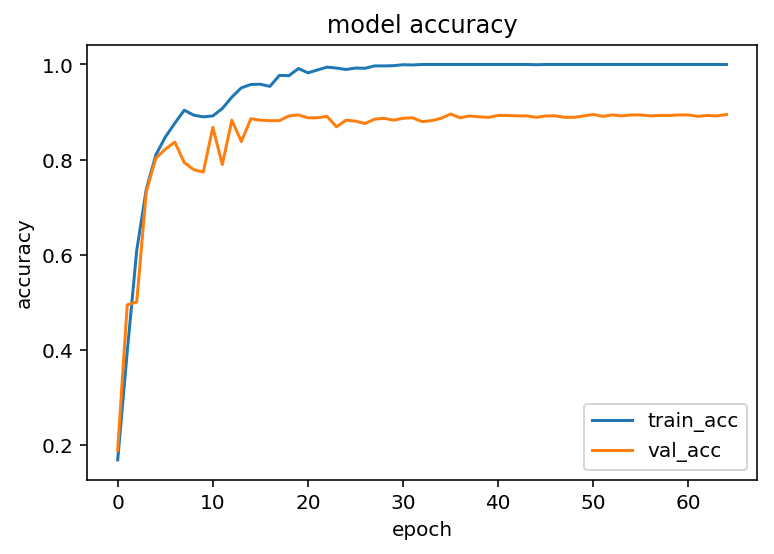

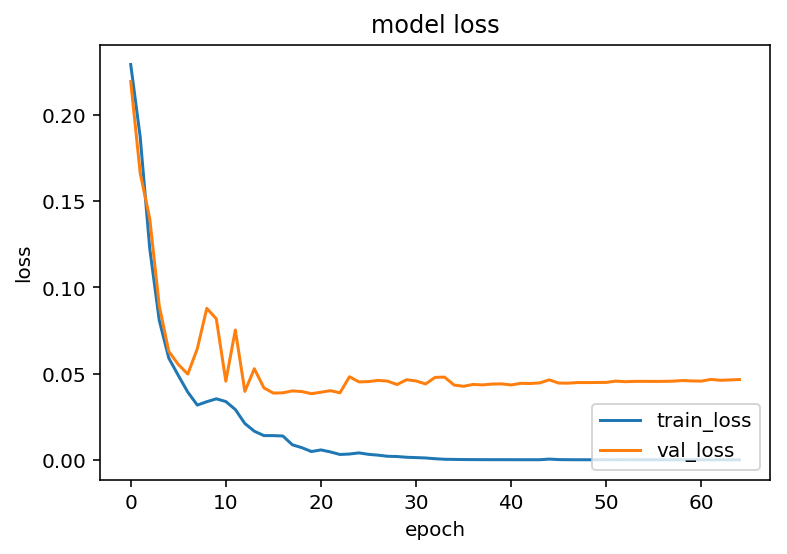

100%|██████████| 20/20 [00:02<00:00,  8.22it/s]
[2017-12-03 00:04:53,061 INFO] TestAcc: 0.9259 | TestLoss: 0.0288 
100%|██████████| 114/114 [00:12<00:00,  9.23it/s]
[2017-12-03 00:05:05,462 INFO] UnlabeledAcc: 0.9142 | UnlabeledLoss: 0.0331 
[2017-12-03 00:05:06,759 INFO] Epoch: 0 | TrainAcc: 0.1815 | TrainLoss: 0.2310
[2017-12-03 00:05:07,176 INFO] Epoch: 0 | ValAcc: 0.2360 | ValLoss: 0.2117 

[2017-12-03 00:05:08,508 INFO] Epoch: 1 | TrainAcc: 0.3505 | TrainLoss: 0.1832
[2017-12-03 00:05:08,873 INFO] Epoch: 1 | ValAcc: 0.4090 | ValLoss: 0.1650 

[2017-12-03 00:05:10,132 INFO] Epoch: 2 | TrainAcc: 0.5080 | TrainLoss: 0.1366
[2017-12-03 00:05:10,512 INFO] Epoch: 2 | ValAcc: 0.6020 | ValLoss: 0.1246 

[2017-12-03 00:05:11,937 INFO] Epoch: 3 | TrainAcc: 0.6250 | TrainLoss: 0.1218
[2017-12-03 00:05:12,400 INFO] Epoch: 3 | ValAcc: 0.5420 | ValLoss: 0.1278 

[2017-12-03 00:05:13,779 INFO] Epoch: 4 | TrainAcc: 0.7155 | TrainLoss: 0.0853
[2017-12-03 00:05:14,135 INFO] Epoch: 4 | ValAcc: 0.769

[2017-12-03 00:06:34,323 INFO] Epoch: 50 | ValAcc: 0.9160 | ValLoss: 0.0382 

[2017-12-03 00:06:35,634 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:06:35,994 INFO] Epoch: 51 | ValAcc: 0.9160 | ValLoss: 0.0385 

[2017-12-03 00:06:37,530 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:06:37,936 INFO] Epoch: 52 | ValAcc: 0.9140 | ValLoss: 0.0387 

[2017-12-03 00:06:39,269 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:06:39,636 INFO] Epoch: 53 | ValAcc: 0.9140 | ValLoss: 0.0385 

[2017-12-03 00:06:40,989 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:06:41,358 INFO] Epoch: 54 | ValAcc: 0.9160 | ValLoss: 0.0391 

[2017-12-03 00:06:42,835 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:06:43,374 INFO] Epoch: 55 | ValAcc: 0.9090 | ValLoss: 0.0389 

[2017-12-03 00:06:44,767 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:06:45,189 INFO] Epoch: 56 | ValAcc: 0

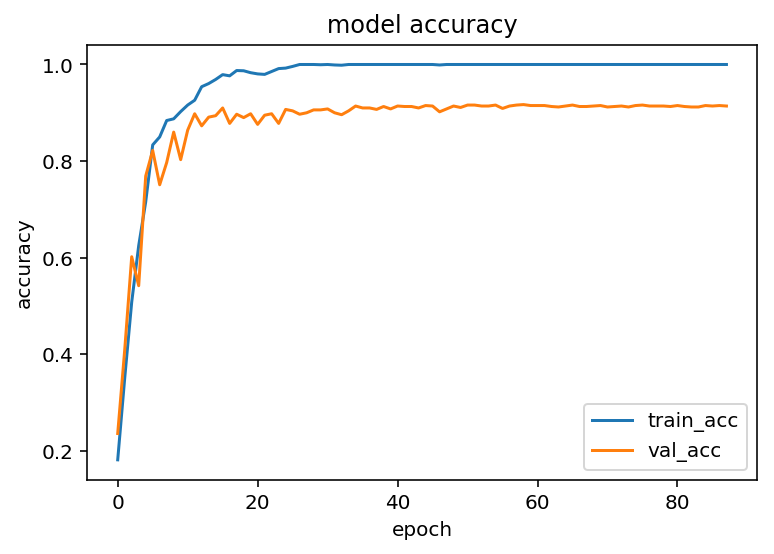

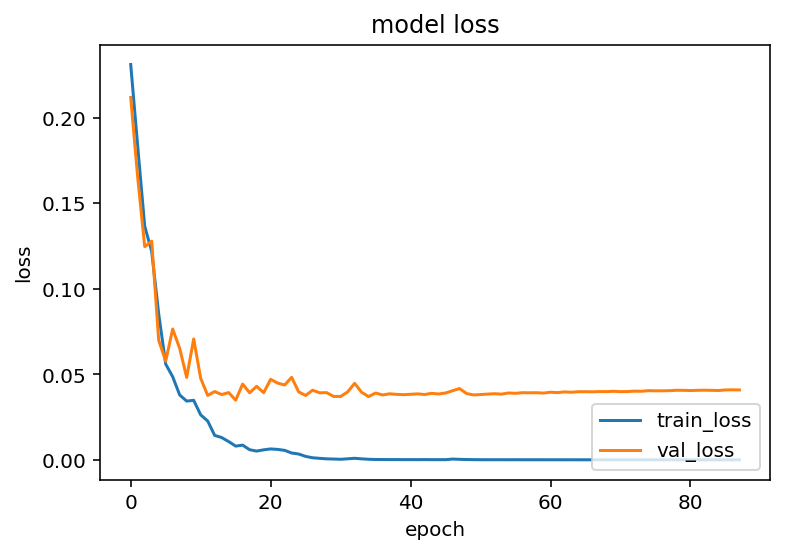

100%|██████████| 20/20 [00:02<00:00,  8.72it/s]
[2017-12-03 00:07:41,765 INFO] TestAcc: 0.9240 | TestLoss: 0.0313 
100%|██████████| 114/114 [00:12<00:00,  9.14it/s]
[2017-12-03 00:07:54,290 INFO] UnlabeledAcc: 0.9153 | UnlabeledLoss: 0.0350 
[2017-12-03 00:07:55,644 INFO] Epoch: 0 | TrainAcc: 0.1390 | TrainLoss: 0.2374
[2017-12-03 00:07:56,021 INFO] Epoch: 0 | ValAcc: 0.1780 | ValLoss: 0.2269 

[2017-12-03 00:07:57,405 INFO] Epoch: 1 | TrainAcc: 0.1890 | TrainLoss: 0.2221
[2017-12-03 00:07:57,779 INFO] Epoch: 1 | ValAcc: 0.1800 | ValLoss: 0.2173 

[2017-12-03 00:07:59,089 INFO] Epoch: 2 | TrainAcc: 0.2670 | TrainLoss: 0.2014
[2017-12-03 00:07:59,450 INFO] Epoch: 2 | ValAcc: 0.3500 | ValLoss: 0.1870 

[2017-12-03 00:08:00,868 INFO] Epoch: 3 | TrainAcc: 0.4420 | TrainLoss: 0.1628
[2017-12-03 00:08:01,282 INFO] Epoch: 3 | ValAcc: 0.5260 | ValLoss: 0.1398 

[2017-12-03 00:08:02,585 INFO] Epoch: 4 | TrainAcc: 0.6290 | TrainLoss: 0.1121
[2017-12-03 00:08:02,928 INFO] Epoch: 4 | ValAcc: 0.544

[2017-12-03 00:09:24,520 INFO] Epoch: 50 | ValAcc: 0.8980 | ValLoss: 0.0415 

[2017-12-03 00:09:25,826 INFO] Epoch: 51 | TrainAcc: 0.9970 | TrainLoss: 0.0014
[2017-12-03 00:09:26,194 INFO] Epoch: 51 | ValAcc: 0.8950 | ValLoss: 0.0417 

[2017-12-03 00:09:27,544 INFO] Epoch: 52 | TrainAcc: 0.9990 | TrainLoss: 0.0008
[2017-12-03 00:09:27,918 INFO] Epoch: 52 | ValAcc: 0.8950 | ValLoss: 0.0416 

[2017-12-03 00:09:29,239 INFO] Epoch: 53 | TrainAcc: 0.9990 | TrainLoss: 0.0009
[2017-12-03 00:09:29,608 INFO] Epoch: 53 | ValAcc: 0.8880 | ValLoss: 0.0439 

[2017-12-03 00:09:30,972 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0005
[2017-12-03 00:09:31,326 INFO] Epoch: 54 | ValAcc: 0.8940 | ValLoss: 0.0432 

[2017-12-03 00:09:32,617 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-03 00:09:32,988 INFO] Epoch: 55 | ValAcc: 0.8880 | ValLoss: 0.0449 

[2017-12-03 00:09:34,277 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-03 00:09:34,629 INFO] Epoch: 56 | ValAcc: 0

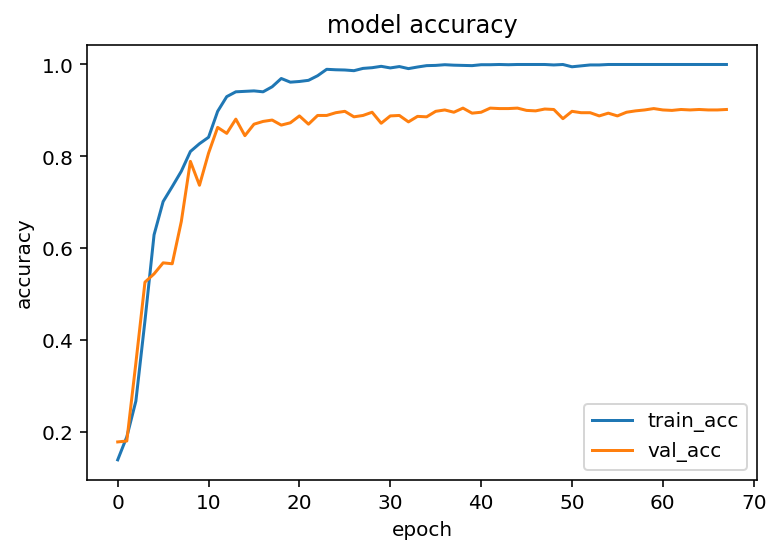

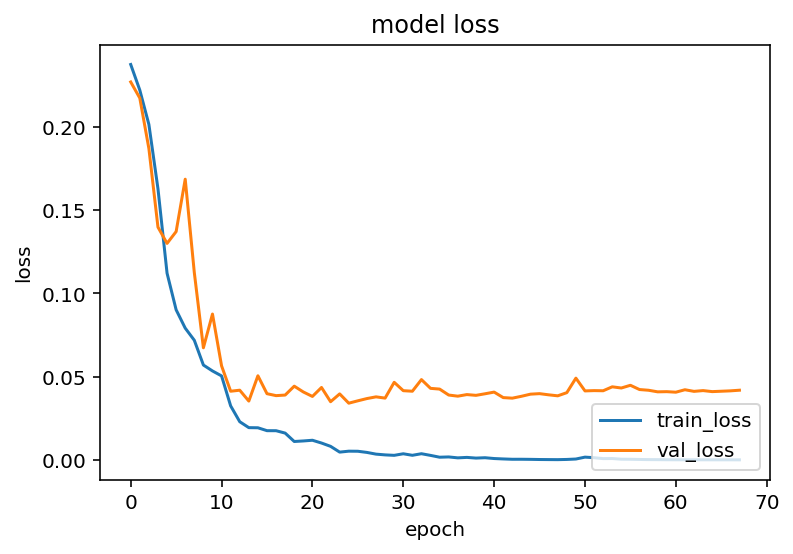

100%|██████████| 20/20 [00:02<00:00,  8.23it/s]
[2017-12-03 00:09:54,938 INFO] TestAcc: 0.9081 | TestLoss: 0.0367 
100%|██████████| 114/114 [00:12<00:00,  8.98it/s]
[2017-12-03 00:10:07,692 INFO] UnlabeledAcc: 0.9028 | UnlabeledLoss: 0.0382 
[2017-12-03 00:10:08,980 INFO] Epoch: 0 | TrainAcc: 0.1225 | TrainLoss: 0.2383
[2017-12-03 00:10:09,349 INFO] Epoch: 0 | ValAcc: 0.1100 | ValLoss: 0.2279 

[2017-12-03 00:10:10,718 INFO] Epoch: 1 | TrainAcc: 0.2040 | TrainLoss: 0.2195
[2017-12-03 00:10:11,106 INFO] Epoch: 1 | ValAcc: 0.2690 | ValLoss: 0.2095 

[2017-12-03 00:10:12,417 INFO] Epoch: 2 | TrainAcc: 0.3720 | TrainLoss: 0.1835
[2017-12-03 00:10:12,768 INFO] Epoch: 2 | ValAcc: 0.3660 | ValLoss: 0.1696 

[2017-12-03 00:10:14,054 INFO] Epoch: 3 | TrainAcc: 0.5420 | TrainLoss: 0.1333
[2017-12-03 00:10:14,408 INFO] Epoch: 3 | ValAcc: 0.5450 | ValLoss: 0.1303 

[2017-12-03 00:10:15,684 INFO] Epoch: 4 | TrainAcc: 0.6795 | TrainLoss: 0.0962
[2017-12-03 00:10:16,053 INFO] Epoch: 4 | ValAcc: 0.631

[2017-12-03 00:11:37,086 INFO] Epoch: 50 | ValAcc: 0.9070 | ValLoss: 0.0380 

[2017-12-03 00:11:38,450 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 00:11:38,850 INFO] Epoch: 51 | ValAcc: 0.9110 | ValLoss: 0.0377 

[2017-12-03 00:11:40,118 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:11:40,476 INFO] Epoch: 52 | ValAcc: 0.9100 | ValLoss: 0.0378 

[2017-12-03 00:11:41,842 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:11:42,243 INFO] Epoch: 53 | ValAcc: 0.9100 | ValLoss: 0.0376 

[2017-12-03 00:11:43,576 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:11:43,963 INFO] Epoch: 54 | ValAcc: 0.9140 | ValLoss: 0.0381 

[2017-12-03 00:11:45,292 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:11:45,649 INFO] Epoch: 55 | ValAcc: 0.9100 | ValLoss: 0.0377 

[2017-12-03 00:11:46,919 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:11:47,259 INFO] Epoch: 56 | ValAcc: 0

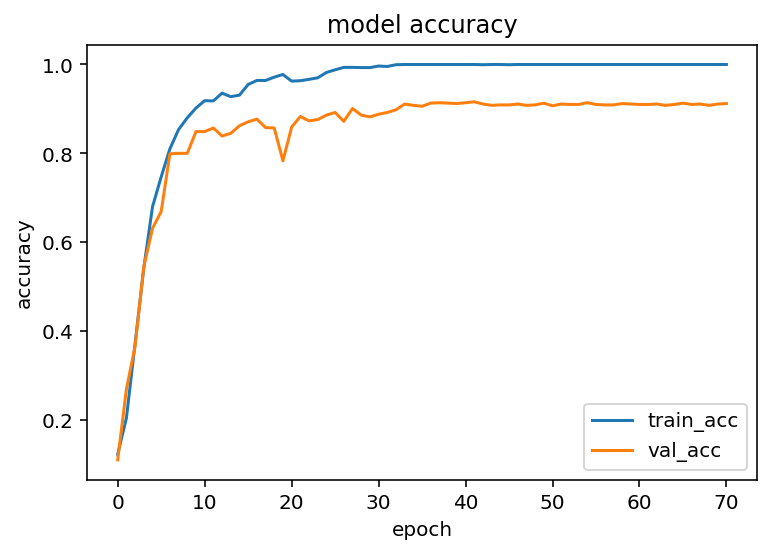

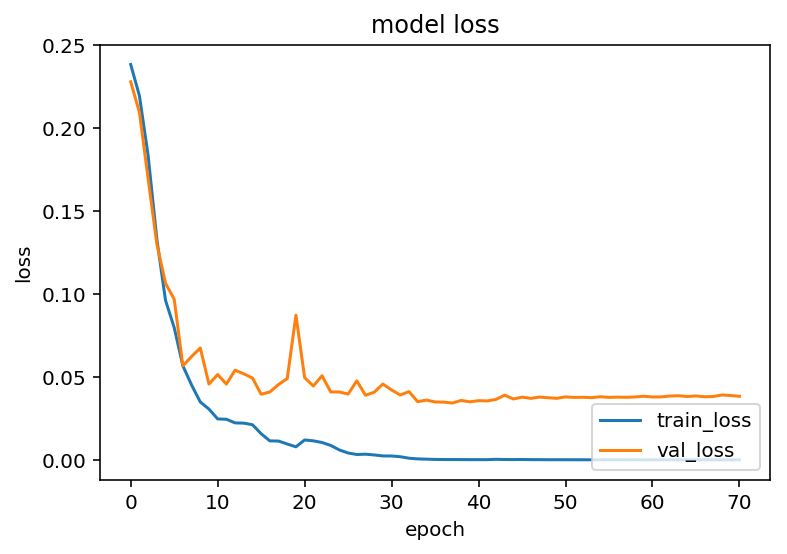

100%|██████████| 20/20 [00:03<00:00,  6.51it/s]
[2017-12-03 00:12:13,492 INFO] TestAcc: 0.9118 | TestLoss: 0.0361 
100%|██████████| 114/114 [00:12<00:00,  8.80it/s]
[2017-12-03 00:12:26,518 INFO] UnlabeledAcc: 0.9021 | UnlabeledLoss: 0.0399 
[2017-12-03 00:12:27,883 INFO] Epoch: 0 | TrainAcc: 0.1900 | TrainLoss: 0.2248
[2017-12-03 00:12:28,280 INFO] Epoch: 0 | ValAcc: 0.2330 | ValLoss: 0.2135 

[2017-12-03 00:12:29,614 INFO] Epoch: 1 | TrainAcc: 0.4715 | TrainLoss: 0.1668
[2017-12-03 00:12:30,011 INFO] Epoch: 1 | ValAcc: 0.5790 | ValLoss: 0.1305 

[2017-12-03 00:12:31,254 INFO] Epoch: 2 | TrainAcc: 0.6715 | TrainLoss: 0.1032
[2017-12-03 00:12:31,593 INFO] Epoch: 2 | ValAcc: 0.7060 | ValLoss: 0.0861 

[2017-12-03 00:12:32,794 INFO] Epoch: 3 | TrainAcc: 0.7950 | TrainLoss: 0.0655
[2017-12-03 00:12:33,139 INFO] Epoch: 3 | ValAcc: 0.7820 | ValLoss: 0.0676 

[2017-12-03 00:12:34,550 INFO] Epoch: 4 | TrainAcc: 0.8200 | TrainLoss: 0.0571
[2017-12-03 00:12:34,979 INFO] Epoch: 4 | ValAcc: 0.764

[2017-12-03 00:13:49,668 INFO] Epoch: 50 | ValAcc: 0.9170 | ValLoss: 0.0393 

[2017-12-03 00:13:50,964 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:13:51,361 INFO] Epoch: 51 | ValAcc: 0.9210 | ValLoss: 0.0385 

[2017-12-03 00:13:52,644 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:13:52,990 INFO] Epoch: 52 | ValAcc: 0.9200 | ValLoss: 0.0392 

[2017-12-03 00:13:54,226 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:13:54,574 INFO] Epoch: 53 | ValAcc: 0.9180 | ValLoss: 0.0394 

[2017-12-03 00:13:55,878 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:13:56,285 INFO] Epoch: 54 | ValAcc: 0.9200 | ValLoss: 0.0390 

[2017-12-03 00:13:57,661 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:13:58,093 INFO] Epoch: 55 | ValAcc: 0.9170 | ValLoss: 0.0394 

[2017-12-03 00:13:59,387 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:13:59,778 INFO] Epoch: 56 | ValAcc: 0

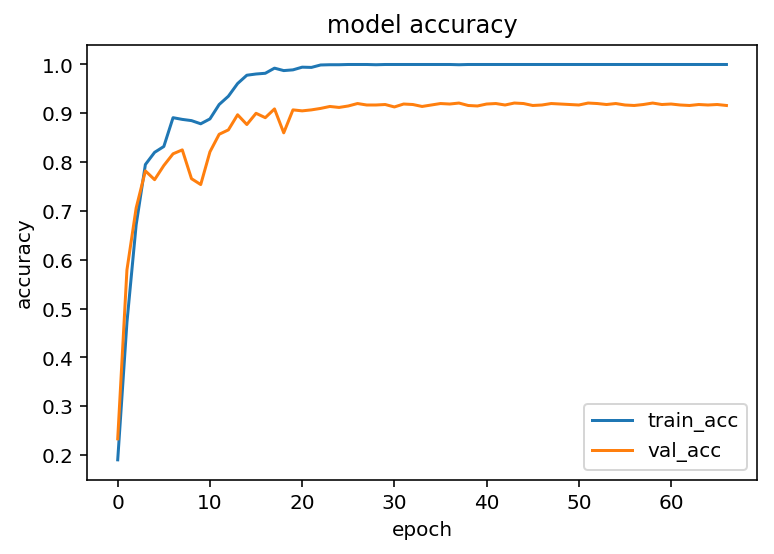

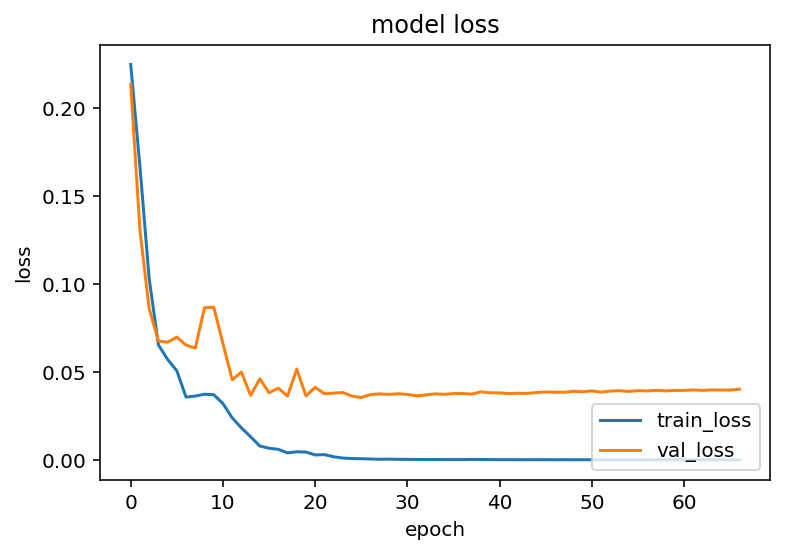

100%|██████████| 20/20 [00:02<00:00,  8.05it/s]
[2017-12-03 00:14:18,859 INFO] TestAcc: 0.9197 | TestLoss: 0.0305 
100%|██████████| 114/114 [00:13<00:00,  8.24it/s]
[2017-12-03 00:14:32,745 INFO] UnlabeledAcc: 0.9097 | UnlabeledLoss: 0.0354 
[2017-12-03 00:14:33,991 INFO] Epoch: 0 | TrainAcc: 0.1230 | TrainLoss: 0.2362
[2017-12-03 00:14:34,337 INFO] Epoch: 0 | ValAcc: 0.2520 | ValLoss: 0.2242 

[2017-12-03 00:14:35,582 INFO] Epoch: 1 | TrainAcc: 0.3145 | TrainLoss: 0.2035
[2017-12-03 00:14:35,927 INFO] Epoch: 1 | ValAcc: 0.3840 | ValLoss: 0.1905 

[2017-12-03 00:14:37,199 INFO] Epoch: 2 | TrainAcc: 0.4975 | TrainLoss: 0.1523
[2017-12-03 00:14:37,541 INFO] Epoch: 2 | ValAcc: 0.5520 | ValLoss: 0.1323 

[2017-12-03 00:14:38,794 INFO] Epoch: 3 | TrainAcc: 0.6465 | TrainLoss: 0.1114
[2017-12-03 00:14:39,145 INFO] Epoch: 3 | ValAcc: 0.5440 | ValLoss: 0.1349 

[2017-12-03 00:14:40,358 INFO] Epoch: 4 | TrainAcc: 0.7065 | TrainLoss: 0.0855
[2017-12-03 00:14:40,706 INFO] Epoch: 4 | ValAcc: 0.569

[2017-12-03 00:16:04,298 INFO] Epoch: 50 | ValAcc: 0.9050 | ValLoss: 0.0402 

[2017-12-03 00:16:05,656 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:16:06,030 INFO] Epoch: 51 | ValAcc: 0.9040 | ValLoss: 0.0401 

[2017-12-03 00:16:07,500 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:16:07,883 INFO] Epoch: 52 | ValAcc: 0.9050 | ValLoss: 0.0405 

[2017-12-03 00:16:09,180 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:16:09,537 INFO] Epoch: 53 | ValAcc: 0.9050 | ValLoss: 0.0397 

[2017-12-03 00:16:10,849 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:16:11,227 INFO] Epoch: 54 | ValAcc: 0.9050 | ValLoss: 0.0403 

[2017-12-03 00:16:12,563 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:16:12,958 INFO] Epoch: 55 | ValAcc: 0.9040 | ValLoss: 0.0402 

[2017-12-03 00:16:14,271 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:16:14,653 INFO] Epoch: 56 | ValAcc: 0

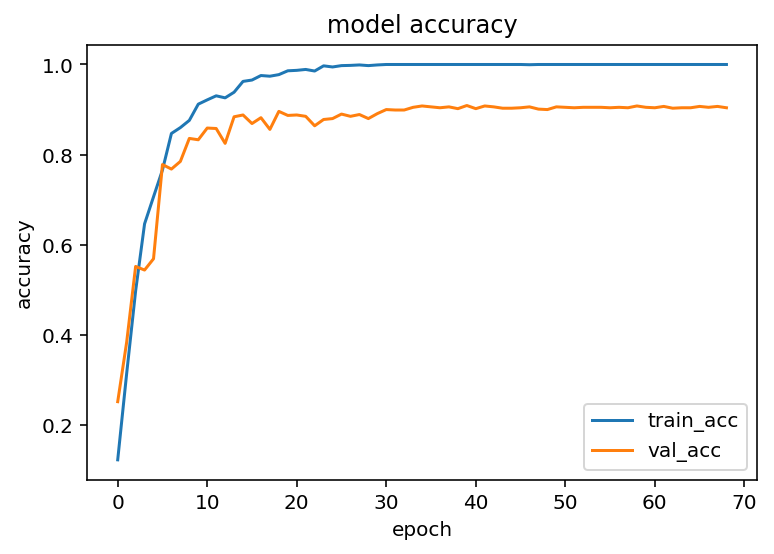

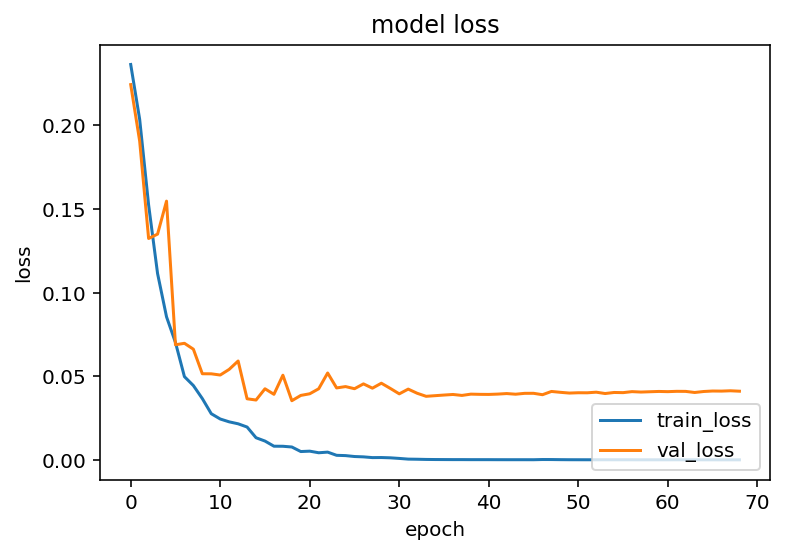

100%|██████████| 20/20 [00:02<00:00,  9.75it/s]
[2017-12-03 00:16:36,766 INFO] TestAcc: 0.9133 | TestLoss: 0.0360 
100%|██████████| 114/114 [00:12<00:00,  9.12it/s]
[2017-12-03 00:16:49,311 INFO] UnlabeledAcc: 0.9082 | UnlabeledLoss: 0.0375 
[2017-12-03 00:16:50,698 INFO] Epoch: 0 | TrainAcc: 0.1215 | TrainLoss: 0.2392
[2017-12-03 00:16:51,177 INFO] Epoch: 0 | ValAcc: 0.1980 | ValLoss: 0.2277 

[2017-12-03 00:16:52,424 INFO] Epoch: 1 | TrainAcc: 0.1925 | TrainLoss: 0.2156
[2017-12-03 00:16:52,765 INFO] Epoch: 1 | ValAcc: 0.2770 | ValLoss: 0.2061 

[2017-12-03 00:16:53,977 INFO] Epoch: 2 | TrainAcc: 0.3905 | TrainLoss: 0.1808
[2017-12-03 00:16:54,313 INFO] Epoch: 2 | ValAcc: 0.4120 | ValLoss: 0.1591 

[2017-12-03 00:16:55,555 INFO] Epoch: 3 | TrainAcc: 0.5650 | TrainLoss: 0.1297
[2017-12-03 00:16:55,906 INFO] Epoch: 3 | ValAcc: 0.3720 | ValLoss: 0.1778 

[2017-12-03 00:16:57,132 INFO] Epoch: 4 | TrainAcc: 0.7205 | TrainLoss: 0.0854
[2017-12-03 00:16:57,472 INFO] Epoch: 4 | ValAcc: 0.674

[2017-12-03 00:18:11,373 INFO] Epoch: 50 | ValAcc: 0.8940 | ValLoss: 0.0457 

[2017-12-03 00:18:12,620 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:18:13,024 INFO] Epoch: 51 | ValAcc: 0.8940 | ValLoss: 0.0459 

[2017-12-03 00:18:14,347 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:18:14,690 INFO] Epoch: 52 | ValAcc: 0.8950 | ValLoss: 0.0458 

[2017-12-03 00:18:15,918 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:18:16,264 INFO] Epoch: 53 | ValAcc: 0.8960 | ValLoss: 0.0460 

[2017-12-03 00:18:17,497 INFO] Epoch: 54 | TrainAcc: 0.9995 | TrainLoss: 0.0002
[2017-12-03 00:18:17,960 INFO] Epoch: 54 | ValAcc: 0.8920 | ValLoss: 0.0454 

[2017-12-03 00:18:19,422 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 00:18:19,858 INFO] Epoch: 55 | ValAcc: 0.8990 | ValLoss: 0.0469 

[2017-12-03 00:18:21,238 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 00:18:21,610 INFO] Epoch: 56 | ValAcc: 0

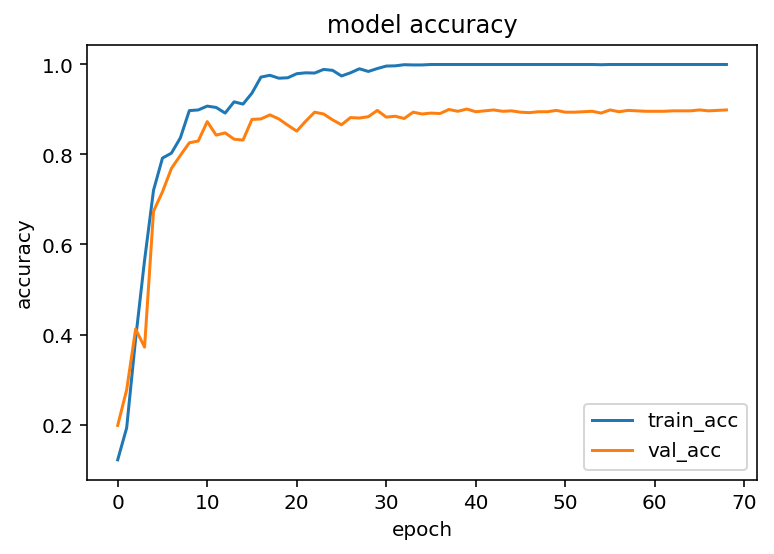

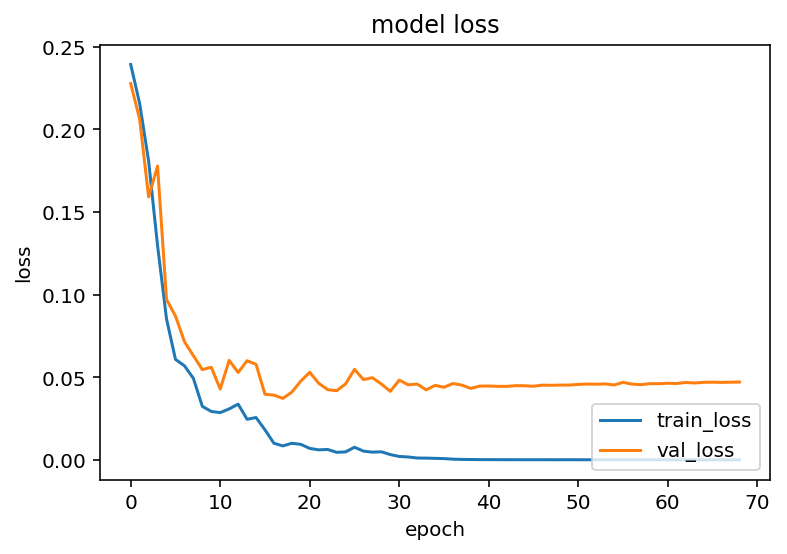

100%|██████████| 20/20 [00:02<00:00,  8.36it/s]
[2017-12-03 00:18:44,615 INFO] TestAcc: 0.9137 | TestLoss: 0.0349 
100%|██████████| 114/114 [00:12<00:00,  9.24it/s]
[2017-12-03 00:18:57,005 INFO] UnlabeledAcc: 0.9071 | UnlabeledLoss: 0.0378 
[2017-12-03 00:18:58,322 INFO] Epoch: 0 | TrainAcc: 0.1825 | TrainLoss: 0.2261
[2017-12-03 00:18:58,721 INFO] Epoch: 0 | ValAcc: 0.2310 | ValLoss: 0.2107 

[2017-12-03 00:19:00,016 INFO] Epoch: 1 | TrainAcc: 0.4275 | TrainLoss: 0.1682
[2017-12-03 00:19:00,373 INFO] Epoch: 1 | ValAcc: 0.5510 | ValLoss: 0.1476 

[2017-12-03 00:19:01,642 INFO] Epoch: 2 | TrainAcc: 0.5765 | TrainLoss: 0.1278
[2017-12-03 00:19:02,095 INFO] Epoch: 2 | ValAcc: 0.6260 | ValLoss: 0.1142 

[2017-12-03 00:19:03,419 INFO] Epoch: 3 | TrainAcc: 0.6955 | TrainLoss: 0.0919
[2017-12-03 00:19:03,888 INFO] Epoch: 3 | ValAcc: 0.4490 | ValLoss: 0.1660 

[2017-12-03 00:19:05,191 INFO] Epoch: 4 | TrainAcc: 0.7630 | TrainLoss: 0.0688
[2017-12-03 00:19:05,550 INFO] Epoch: 4 | ValAcc: 0.642

[2017-12-03 00:20:24,813 INFO] Epoch: 50 | ValAcc: 0.9000 | ValLoss: 0.0438 

[2017-12-03 00:20:26,142 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:20:26,494 INFO] Epoch: 51 | ValAcc: 0.9010 | ValLoss: 0.0435 

[2017-12-03 00:20:27,713 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:20:28,043 INFO] Epoch: 52 | ValAcc: 0.9040 | ValLoss: 0.0434 

[2017-12-03 00:20:29,227 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:20:29,565 INFO] Epoch: 53 | ValAcc: 0.9010 | ValLoss: 0.0435 

[2017-12-03 00:20:30,781 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:20:31,119 INFO] Epoch: 54 | ValAcc: 0.8990 | ValLoss: 0.0439 

[2017-12-03 00:20:32,336 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:20:32,674 INFO] Epoch: 55 | ValAcc: 0.9000 | ValLoss: 0.0437 

[2017-12-03 00:20:33,972 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:20:34,317 INFO] Epoch: 56 | ValAcc: 0

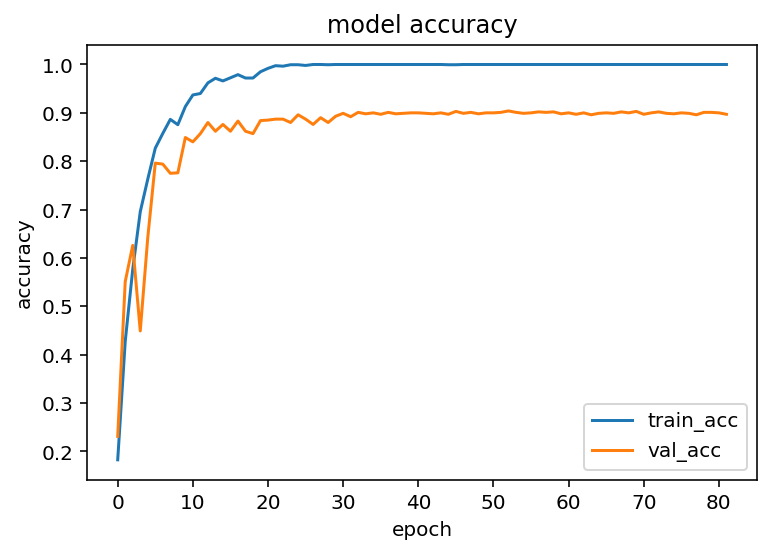

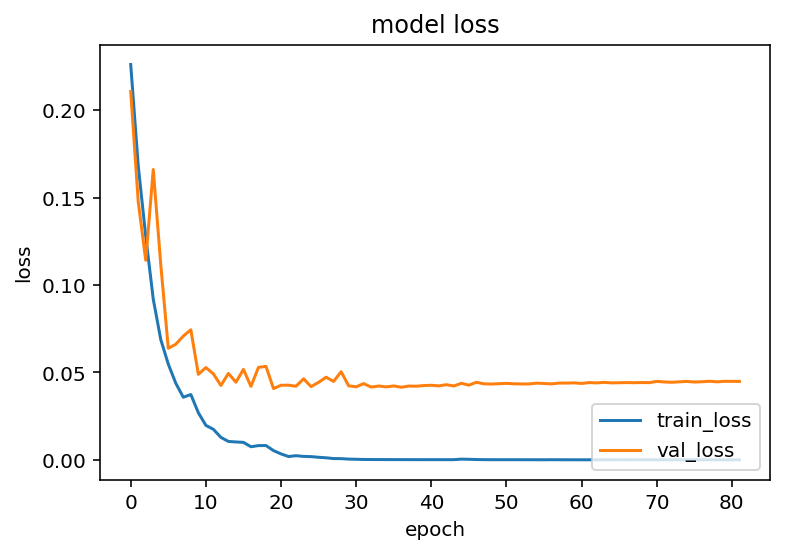

100%|██████████| 20/20 [00:02<00:00,  8.90it/s]
[2017-12-03 00:21:21,198 INFO] TestAcc: 0.9169 | TestLoss: 0.0325 
100%|██████████| 114/114 [00:12<00:00,  9.13it/s]
[2017-12-03 00:21:33,736 INFO] UnlabeledAcc: 0.9070 | UnlabeledLoss: 0.0387 
[2017-12-03 00:21:34,958 INFO] Epoch: 0 | TrainAcc: 0.1300 | TrainLoss: 0.2415
[2017-12-03 00:21:35,312 INFO] Epoch: 0 | ValAcc: 0.1330 | ValLoss: 0.2254 

[2017-12-03 00:21:36,549 INFO] Epoch: 1 | TrainAcc: 0.2890 | TrainLoss: 0.2102
[2017-12-03 00:21:36,889 INFO] Epoch: 1 | ValAcc: 0.4330 | ValLoss: 0.1981 

[2017-12-03 00:21:38,127 INFO] Epoch: 2 | TrainAcc: 0.4870 | TrainLoss: 0.1617
[2017-12-03 00:21:38,467 INFO] Epoch: 2 | ValAcc: 0.4310 | ValLoss: 0.1635 

[2017-12-03 00:21:39,685 INFO] Epoch: 3 | TrainAcc: 0.5995 | TrainLoss: 0.1191
[2017-12-03 00:21:40,016 INFO] Epoch: 3 | ValAcc: 0.3350 | ValLoss: 0.2004 

[2017-12-03 00:21:41,244 INFO] Epoch: 4 | TrainAcc: 0.6790 | TrainLoss: 0.0957
[2017-12-03 00:21:41,595 INFO] Epoch: 4 | ValAcc: 0.561

[2017-12-03 00:23:03,094 INFO] Epoch: 50 | ValAcc: 0.8840 | ValLoss: 0.0562 

[2017-12-03 00:23:04,375 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 00:23:04,723 INFO] Epoch: 51 | ValAcc: 0.8840 | ValLoss: 0.0560 

[2017-12-03 00:23:05,952 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 00:23:06,312 INFO] Epoch: 52 | ValAcc: 0.8810 | ValLoss: 0.0564 

[2017-12-03 00:23:07,540 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 00:23:07,887 INFO] Epoch: 53 | ValAcc: 0.8840 | ValLoss: 0.0565 

[2017-12-03 00:23:09,213 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 00:23:09,568 INFO] Epoch: 54 | ValAcc: 0.8890 | ValLoss: 0.0563 

[2017-12-03 00:23:10,956 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 00:23:11,342 INFO] Epoch: 55 | ValAcc: 0.8870 | ValLoss: 0.0565 

[2017-12-03 00:23:12,765 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:23:13,163 INFO] Epoch: 56 | ValAcc: 0

[2017-12-03 00:24:28,862 INFO] Epoch: 102 | ValAcc: 0.8870 | ValLoss: 0.0599 

[2017-12-03 00:24:30,082 INFO] Epoch: 103 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:24:30,426 INFO] Epoch: 103 | ValAcc: 0.8870 | ValLoss: 0.0604 

[2017-12-03 00:24:31,651 INFO] Epoch: 104 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:24:31,999 INFO] Epoch: 104 | ValAcc: 0.8880 | ValLoss: 0.0603 

[2017-12-03 00:24:32,024 INFO] Accuracy dose not improve for a long epochs
[2017-12-03 00:24:32,026 INFO] Train done.
[2017-12-03 00:24:32,027 INFO] Elapsed Time: 178.2640221118927


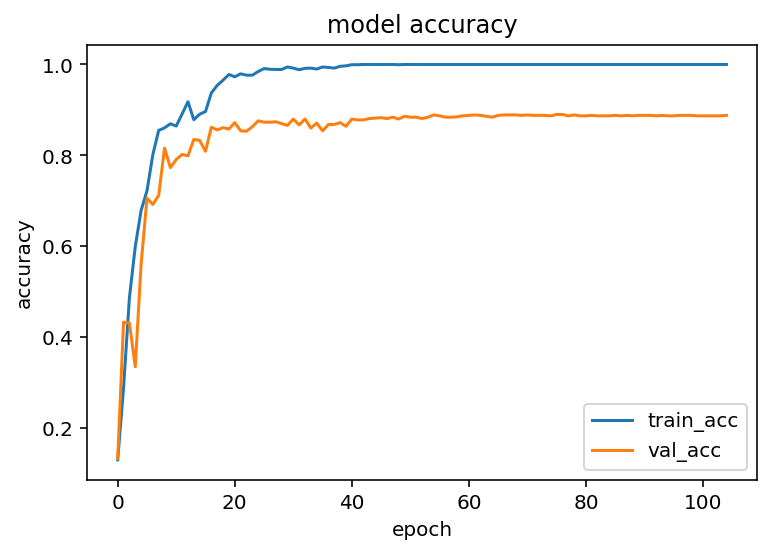

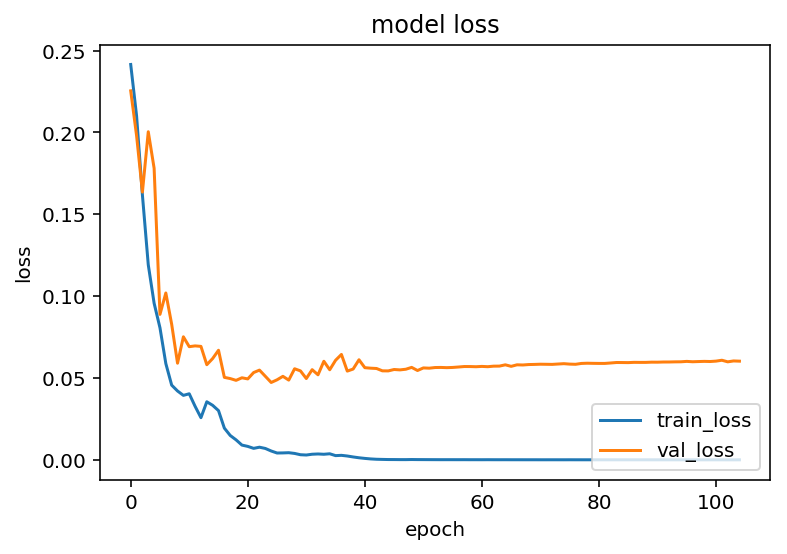

100%|██████████| 20/20 [00:02<00:00,  8.82it/s]
[2017-12-03 00:24:34,580 INFO] TestAcc: 0.9020 | TestLoss: 0.0426 
100%|██████████| 114/114 [00:11<00:00,  9.56it/s]
[2017-12-03 00:24:46,559 INFO] UnlabeledAcc: 0.8899 | UnlabeledLoss: 0.0493 
[2017-12-03 00:24:47,819 INFO] Epoch: 0 | TrainAcc: 0.1700 | TrainLoss: 0.2274
[2017-12-03 00:24:48,171 INFO] Epoch: 0 | ValAcc: 0.3500 | ValLoss: 0.2181 

[2017-12-03 00:24:49,411 INFO] Epoch: 1 | TrainAcc: 0.4155 | TrainLoss: 0.1855
[2017-12-03 00:24:49,759 INFO] Epoch: 1 | ValAcc: 0.4520 | ValLoss: 0.1629 

[2017-12-03 00:24:51,012 INFO] Epoch: 2 | TrainAcc: 0.5930 | TrainLoss: 0.1266
[2017-12-03 00:24:51,359 INFO] Epoch: 2 | ValAcc: 0.4180 | ValLoss: 0.1791 

[2017-12-03 00:24:52,638 INFO] Epoch: 3 | TrainAcc: 0.7150 | TrainLoss: 0.0858
[2017-12-03 00:24:52,987 INFO] Epoch: 3 | ValAcc: 0.6740 | ValLoss: 0.1033 

[2017-12-03 00:24:54,217 INFO] Epoch: 4 | TrainAcc: 0.8290 | TrainLoss: 0.0527
[2017-12-03 00:24:54,557 INFO] Epoch: 4 | ValAcc: 0.829

[2017-12-03 00:26:12,422 INFO] Epoch: 50 | ValAcc: 0.9170 | ValLoss: 0.0386 

[2017-12-03 00:26:13,663 INFO] Epoch: 51 | TrainAcc: 0.9995 | TrainLoss: 0.0002
[2017-12-03 00:26:14,020 INFO] Epoch: 51 | ValAcc: 0.9110 | ValLoss: 0.0398 

[2017-12-03 00:26:15,255 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:26:15,603 INFO] Epoch: 52 | ValAcc: 0.9120 | ValLoss: 0.0413 

[2017-12-03 00:26:16,838 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:26:17,195 INFO] Epoch: 53 | ValAcc: 0.9130 | ValLoss: 0.0398 

[2017-12-03 00:26:18,431 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:26:18,773 INFO] Epoch: 54 | ValAcc: 0.9150 | ValLoss: 0.0397 

[2017-12-03 00:26:20,030 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:26:20,368 INFO] Epoch: 55 | ValAcc: 0.9140 | ValLoss: 0.0398 

[2017-12-03 00:26:21,603 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:26:21,944 INFO] Epoch: 56 | ValAcc: 0

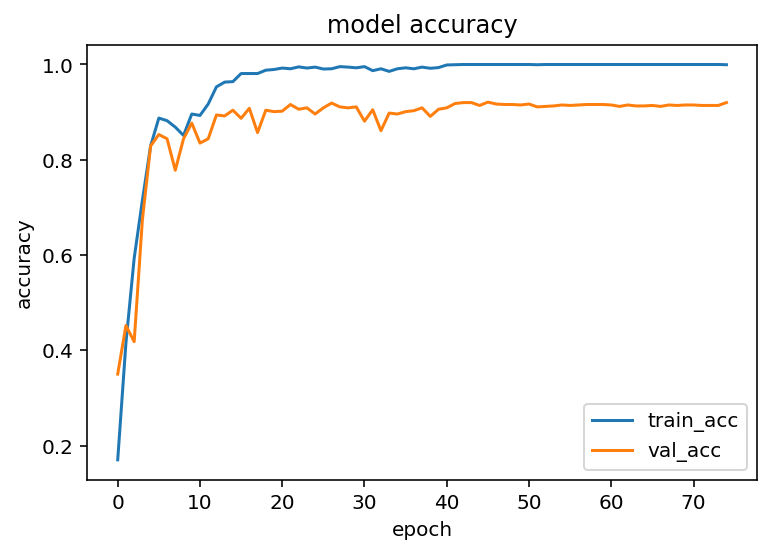

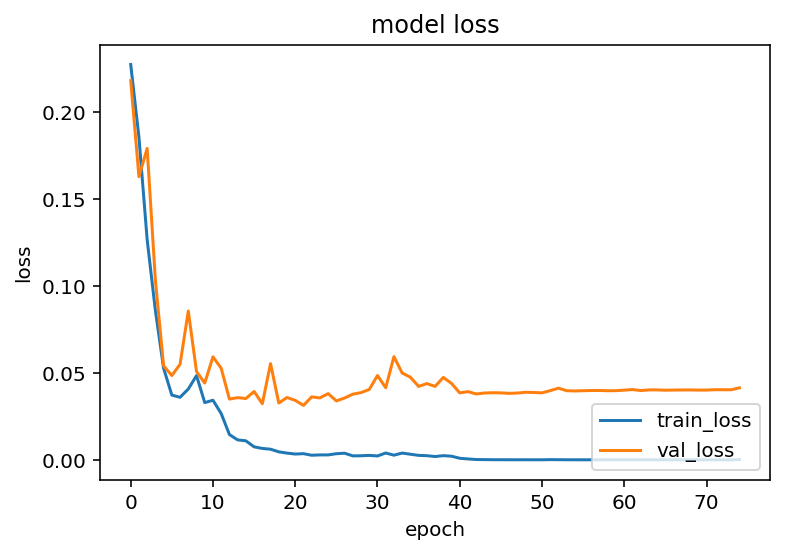

100%|██████████| 20/20 [00:02<00:00,  8.75it/s]
[2017-12-03 00:26:54,701 INFO] TestAcc: 0.9287 | TestLoss: 0.0304 
100%|██████████| 114/114 [00:12<00:00,  9.28it/s]
[2017-12-03 00:27:07,047 INFO] UnlabeledAcc: 0.9189 | UnlabeledLoss: 0.0348 
[2017-12-03 00:27:08,271 INFO] Epoch: 0 | TrainAcc: 0.1710 | TrainLoss: 0.2351
[2017-12-03 00:27:08,616 INFO] Epoch: 0 | ValAcc: 0.2090 | ValLoss: 0.2178 

[2017-12-03 00:27:09,900 INFO] Epoch: 1 | TrainAcc: 0.3935 | TrainLoss: 0.1875
[2017-12-03 00:27:10,254 INFO] Epoch: 1 | ValAcc: 0.4110 | ValLoss: 0.1711 

[2017-12-03 00:27:11,525 INFO] Epoch: 2 | TrainAcc: 0.5590 | TrainLoss: 0.1315
[2017-12-03 00:27:11,861 INFO] Epoch: 2 | ValAcc: 0.5100 | ValLoss: 0.1525 

[2017-12-03 00:27:13,172 INFO] Epoch: 3 | TrainAcc: 0.6585 | TrainLoss: 0.1003
[2017-12-03 00:27:13,533 INFO] Epoch: 3 | ValAcc: 0.5830 | ValLoss: 0.1240 

[2017-12-03 00:27:14,844 INFO] Epoch: 4 | TrainAcc: 0.7695 | TrainLoss: 0.0677
[2017-12-03 00:27:15,207 INFO] Epoch: 4 | ValAcc: 0.664

[2017-12-03 00:28:29,644 INFO] Epoch: 50 | ValAcc: 0.8970 | ValLoss: 0.0426 

[2017-12-03 00:28:30,898 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:28:31,267 INFO] Epoch: 51 | ValAcc: 0.8980 | ValLoss: 0.0428 

[2017-12-03 00:28:32,544 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:28:32,881 INFO] Epoch: 52 | ValAcc: 0.8990 | ValLoss: 0.0427 

[2017-12-03 00:28:34,123 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:28:34,480 INFO] Epoch: 53 | ValAcc: 0.8990 | ValLoss: 0.0428 

[2017-12-03 00:28:35,731 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:28:36,082 INFO] Epoch: 54 | ValAcc: 0.8950 | ValLoss: 0.0430 

[2017-12-03 00:28:37,346 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:28:37,702 INFO] Epoch: 55 | ValAcc: 0.8970 | ValLoss: 0.0431 

[2017-12-03 00:28:38,939 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:28:39,291 INFO] Epoch: 56 | ValAcc: 0

[2017-12-03 00:29:53,916 INFO] Epoch: 102 | ValAcc: 0.8980 | ValLoss: 0.0450 

[2017-12-03 00:29:53,939 INFO] Accuracy dose not improve for a long epochs
[2017-12-03 00:29:53,941 INFO] Train done.
[2017-12-03 00:29:53,943 INFO] Elapsed Time: 166.86436319351196


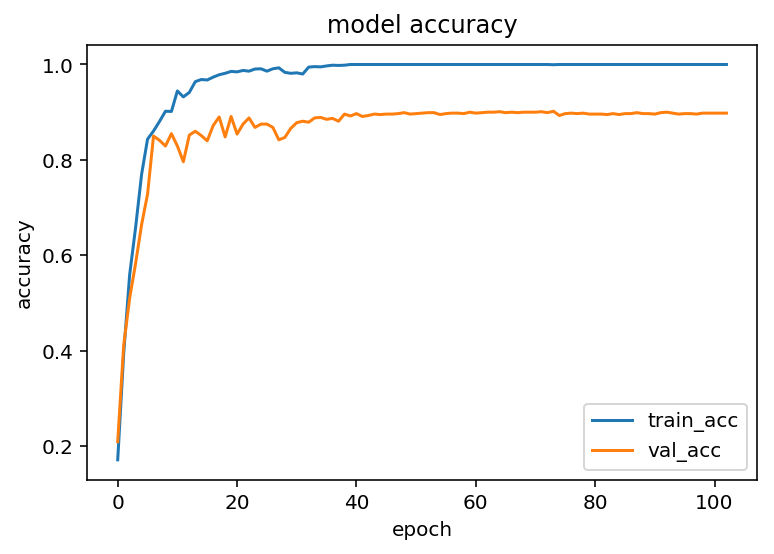

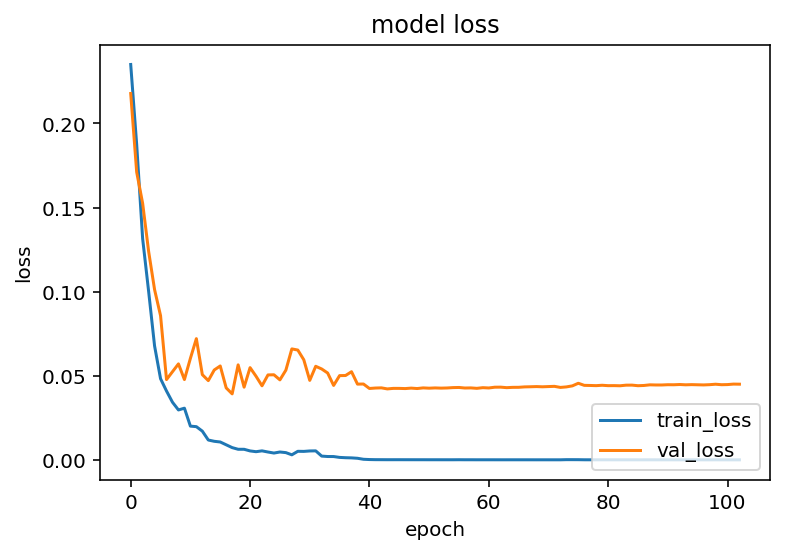

100%|██████████| 20/20 [00:02<00:00,  8.66it/s]
[2017-12-03 00:29:56,527 INFO] TestAcc: 0.9146 | TestLoss: 0.0396 
100%|██████████| 114/114 [00:12<00:00,  9.40it/s]
[2017-12-03 00:30:08,705 INFO] UnlabeledAcc: 0.9034 | UnlabeledLoss: 0.0451 
[2017-12-03 00:30:09,922 INFO] Epoch: 0 | TrainAcc: 0.1700 | TrainLoss: 0.2320
[2017-12-03 00:30:10,285 INFO] Epoch: 0 | ValAcc: 0.1270 | ValLoss: 0.2245 

[2017-12-03 00:30:11,550 INFO] Epoch: 1 | TrainAcc: 0.3805 | TrainLoss: 0.1858
[2017-12-03 00:30:11,898 INFO] Epoch: 1 | ValAcc: 0.4780 | ValLoss: 0.1606 

[2017-12-03 00:30:13,180 INFO] Epoch: 2 | TrainAcc: 0.6195 | TrainLoss: 0.1151
[2017-12-03 00:30:13,540 INFO] Epoch: 2 | ValAcc: 0.6530 | ValLoss: 0.0978 

[2017-12-03 00:30:14,814 INFO] Epoch: 3 | TrainAcc: 0.7545 | TrainLoss: 0.0744
[2017-12-03 00:30:15,179 INFO] Epoch: 3 | ValAcc: 0.7200 | ValLoss: 0.0860 

[2017-12-03 00:30:16,445 INFO] Epoch: 4 | TrainAcc: 0.8360 | TrainLoss: 0.0488
[2017-12-03 00:30:16,785 INFO] Epoch: 4 | ValAcc: 0.814

[2017-12-03 00:31:31,526 INFO] Epoch: 50 | ValAcc: 0.8870 | ValLoss: 0.0440 

[2017-12-03 00:31:32,795 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:31:33,149 INFO] Epoch: 51 | ValAcc: 0.8930 | ValLoss: 0.0439 

[2017-12-03 00:31:34,407 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:31:34,753 INFO] Epoch: 52 | ValAcc: 0.8880 | ValLoss: 0.0446 

[2017-12-03 00:31:36,008 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:31:36,358 INFO] Epoch: 53 | ValAcc: 0.8890 | ValLoss: 0.0443 

[2017-12-03 00:31:37,622 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:31:37,960 INFO] Epoch: 54 | ValAcc: 0.8850 | ValLoss: 0.0445 

[2017-12-03 00:31:39,255 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:31:39,607 INFO] Epoch: 55 | ValAcc: 0.8860 | ValLoss: 0.0447 

[2017-12-03 00:31:40,866 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:31:41,221 INFO] Epoch: 56 | ValAcc: 0

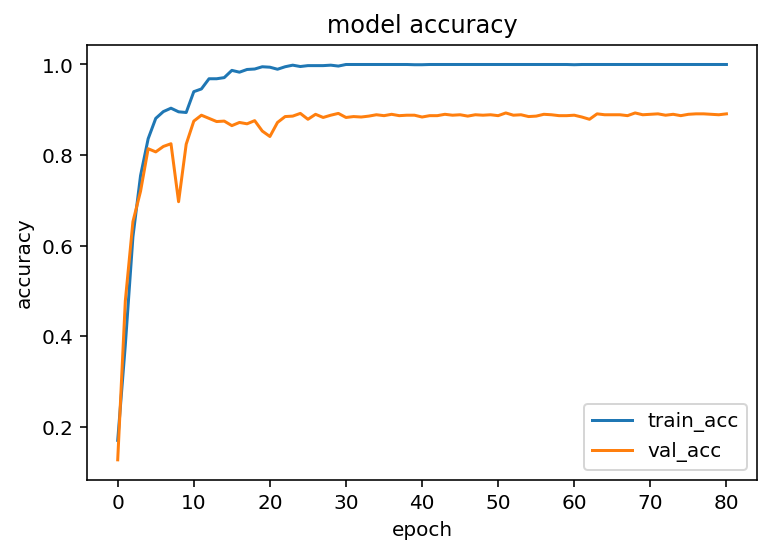

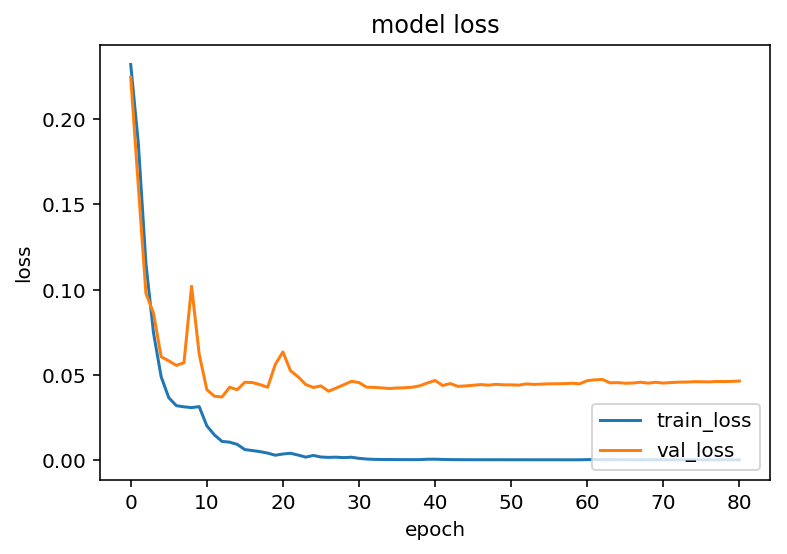

100%|██████████| 20/20 [00:02<00:00,  7.07it/s]
[2017-12-03 00:32:26,279 INFO] TestAcc: 0.9143 | TestLoss: 0.0355 
100%|██████████| 114/114 [00:13<00:00,  8.69it/s]
[2017-12-03 00:32:39,458 INFO] UnlabeledAcc: 0.9066 | UnlabeledLoss: 0.0387 
[2017-12-03 00:32:40,788 INFO] Epoch: 0 | TrainAcc: 0.1905 | TrainLoss: 0.2266
[2017-12-03 00:32:41,284 INFO] Epoch: 0 | ValAcc: 0.2520 | ValLoss: 0.2178 

[2017-12-03 00:32:42,781 INFO] Epoch: 1 | TrainAcc: 0.3895 | TrainLoss: 0.1861
[2017-12-03 00:32:43,332 INFO] Epoch: 1 | ValAcc: 0.4330 | ValLoss: 0.1639 

[2017-12-03 00:32:44,880 INFO] Epoch: 2 | TrainAcc: 0.5810 | TrainLoss: 0.1249
[2017-12-03 00:32:45,343 INFO] Epoch: 2 | ValAcc: 0.4930 | ValLoss: 0.1357 

[2017-12-03 00:32:47,032 INFO] Epoch: 3 | TrainAcc: 0.6985 | TrainLoss: 0.0879
[2017-12-03 00:32:47,579 INFO] Epoch: 3 | ValAcc: 0.5760 | ValLoss: 0.1329 

[2017-12-03 00:32:49,527 INFO] Epoch: 4 | TrainAcc: 0.7355 | TrainLoss: 0.0742
[2017-12-03 00:32:50,102 INFO] Epoch: 4 | ValAcc: 0.679

[2017-12-03 00:34:20,210 INFO] Epoch: 50 | ValAcc: 0.8950 | ValLoss: 0.0431 

[2017-12-03 00:34:21,513 INFO] Epoch: 51 | TrainAcc: 1.0000 | TrainLoss: 0.0004
[2017-12-03 00:34:22,090 INFO] Epoch: 51 | ValAcc: 0.8900 | ValLoss: 0.0479 

[2017-12-03 00:34:23,706 INFO] Epoch: 52 | TrainAcc: 1.0000 | TrainLoss: 0.0003
[2017-12-03 00:34:24,321 INFO] Epoch: 52 | ValAcc: 0.8880 | ValLoss: 0.0467 

[2017-12-03 00:34:25,708 INFO] Epoch: 53 | TrainAcc: 1.0000 | TrainLoss: 0.0002
[2017-12-03 00:34:26,187 INFO] Epoch: 53 | ValAcc: 0.8940 | ValLoss: 0.0431 

[2017-12-03 00:34:27,918 INFO] Epoch: 54 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:34:28,443 INFO] Epoch: 54 | ValAcc: 0.8930 | ValLoss: 0.0444 

[2017-12-03 00:34:29,862 INFO] Epoch: 55 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:34:30,338 INFO] Epoch: 55 | ValAcc: 0.8960 | ValLoss: 0.0434 

[2017-12-03 00:34:31,709 INFO] Epoch: 56 | TrainAcc: 1.0000 | TrainLoss: 0.0001
[2017-12-03 00:34:32,479 INFO] Epoch: 56 | ValAcc: 0

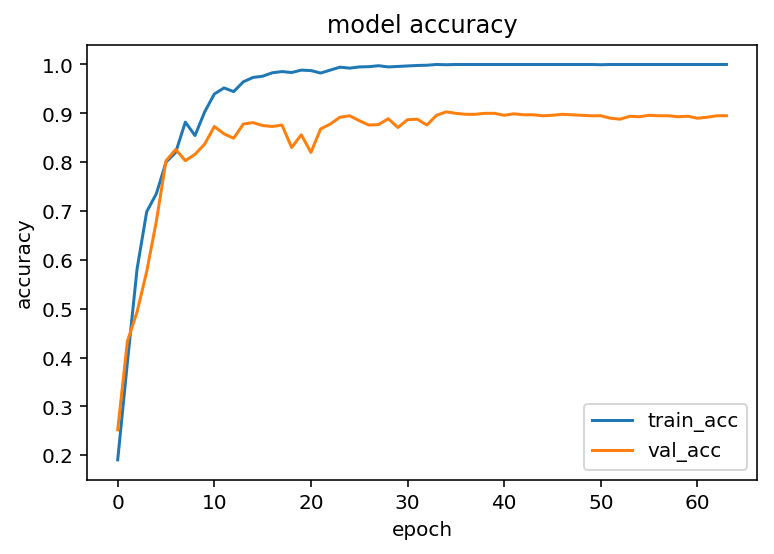

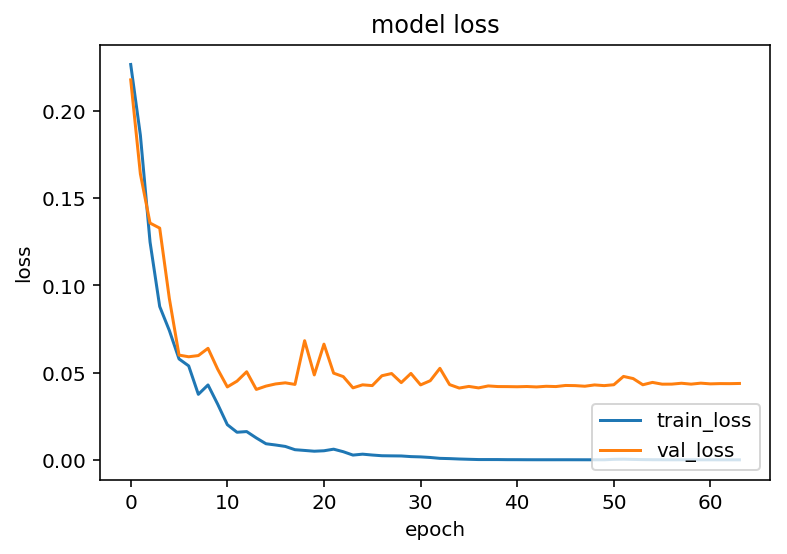

100%|██████████| 20/20 [00:02<00:00,  9.00it/s]
[2017-12-03 00:34:49,204 INFO] TestAcc: 0.9106 | TestLoss: 0.0356 
100%|██████████| 114/114 [00:12<00:00,  9.00it/s]
[2017-12-03 00:35:01,918 INFO] UnlabeledAcc: 0.9033 | UnlabeledLoss: 0.0390 
[2017-12-03 00:35:03,128 INFO] Epoch: 0 | TrainAcc: 0.1900 | TrainLoss: 0.2261
[2017-12-03 00:35:03,485 INFO] Epoch: 0 | ValAcc: 0.2790 | ValLoss: 0.2158 



In [ ]:
# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
ratio_pl = 1.0 # ratio of train:pseudo
hard = True
ex_name = 'pseudo_hard'
trial_times = 30

logzero.logfile('./log/{}.log'.format(ex_name))

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

results = {}
results['test_acc'] = np.empty((trial_times))
results['test_loss'] = np.empty((trial_times))
results['unlabeled_acc'] = np.empty((trial_times))
results['unlabeled_loss'] = np.empty((trial_times))
for i in range(trial_times):
    train_dataset = MNISTDatasetForPseudoLabeling(
        X_train, y_train, X_unlabeled, y_pseudo, ratio_pl, hard, transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_dataset = MNISTDataset(X_val, y_val, transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch_size, num_workers=num_workers)
    test_dataset = MNISTDataset(X_test, y_test, transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, num_workers=num_workers)
    unlabeled_dataset = MNISTDataset(X_unlabeled, y_unlabeled, transform)
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset, batch_size=test_batch_size, num_workers=num_workers)

    model = Net()
    if use_gpu:
        model.cuda()

    def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
        torch.save(state, filename)

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch

        _train(model, train_loader, criterion, optimizer, tracker)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results['test_acc'][i], results['test_loss'][i] = _test(model, test_loader, criterion)
    results['unlabeled_acc'][i], results['unlabeled_loss'][i] = \
        _test(model, unlabeled_loader, criterion, unlabeled=True)

In [ ]:
logger.info('Test Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results['test_acc']),
    np.std(results['test_acc'])
))
logger.info('Test Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results['test_loss']),
    np.std(results['test_loss'])
))

logger.info('Unlabeled Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results['unlabeled_acc']),
    np.std(results['unlabeled_acc'])
))
logger.info('Unlabeled Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results['unlabeled_loss']),
    np.std(results['unlabeled_loss'])
))

In [ ]:
from scipy import stats

t, p = stats.ttest_ind(results['test_acc'], results['unlabeled_acc'], equal_var=False)
print( "p値 = %(p)s" %locals() )

## Soft Pseudo Label

[2017-12-02 23:10:43,499 INFO] Epoch: 0 | TrainAcc: 0.1433 | TrainLoss: 0.2265
[2017-12-02 23:10:43,896 INFO] Epoch: 0 | ValAcc: 0.2010 | ValLoss: 0.2253 

[2017-12-02 23:10:44,935 INFO] Epoch: 1 | TrainAcc: 0.2960 | TrainLoss: 0.1990
[2017-12-02 23:10:45,330 INFO] Epoch: 1 | ValAcc: 0.2920 | ValLoss: 0.2010 

[2017-12-02 23:10:46,313 INFO] Epoch: 2 | TrainAcc: 0.4140 | TrainLoss: 0.1653
[2017-12-02 23:10:46,679 INFO] Epoch: 2 | ValAcc: 0.4810 | ValLoss: 0.1603 

[2017-12-02 23:10:47,722 INFO] Epoch: 3 | TrainAcc: 0.5633 | TrainLoss: 0.1219
[2017-12-02 23:10:48,081 INFO] Epoch: 3 | ValAcc: 0.6160 | ValLoss: 0.1129 

[2017-12-02 23:10:49,055 INFO] Epoch: 4 | TrainAcc: 0.7453 | TrainLoss: 0.0806
[2017-12-02 23:10:49,412 INFO] Epoch: 4 | ValAcc: 0.6500 | ValLoss: 0.1083 

[2017-12-02 23:10:50,508 INFO] Epoch: 5 | TrainAcc: 0.7553 | TrainLoss: 0.0685
[2017-12-02 23:10:50,903 INFO] Epoch: 5 | ValAcc: 0.6950 | ValLoss: 0.0976 

[2017-12-02 23:10:51,983 INFO] Epoch: 6 | TrainAcc: 0.7953 | Tra

[2017-12-02 23:11:59,717 INFO] Epoch: 52 | TrainAcc: 0.9847 | TrainLoss: 0.0052
[2017-12-02 23:12:00,102 INFO] Epoch: 52 | ValAcc: 0.8980 | ValLoss: 0.0376 

[2017-12-02 23:12:01,288 INFO] Epoch: 53 | TrainAcc: 0.9853 | TrainLoss: 0.0048
[2017-12-02 23:12:01,676 INFO] Epoch: 53 | ValAcc: 0.8930 | ValLoss: 0.0352 

[2017-12-02 23:12:02,738 INFO] Epoch: 54 | TrainAcc: 0.9913 | TrainLoss: 0.0042
[2017-12-02 23:12:03,146 INFO] Epoch: 54 | ValAcc: 0.8870 | ValLoss: 0.0401 

[2017-12-02 23:12:04,256 INFO] Epoch: 55 | TrainAcc: 0.9773 | TrainLoss: 0.0042
[2017-12-02 23:12:04,650 INFO] Epoch: 55 | ValAcc: 0.8840 | ValLoss: 0.0387 

[2017-12-02 23:12:05,799 INFO] Epoch: 56 | TrainAcc: 0.9840 | TrainLoss: 0.0041
[2017-12-02 23:12:06,200 INFO] Epoch: 56 | ValAcc: 0.8940 | ValLoss: 0.0387 

[2017-12-02 23:12:07,227 INFO] Epoch: 57 | TrainAcc: 0.9880 | TrainLoss: 0.0043
[2017-12-02 23:12:07,629 INFO] Epoch: 57 | ValAcc: 0.8980 | ValLoss: 0.0345 

[2017-12-02 23:12:08,691 INFO] Epoch: 58 | TrainAcc:

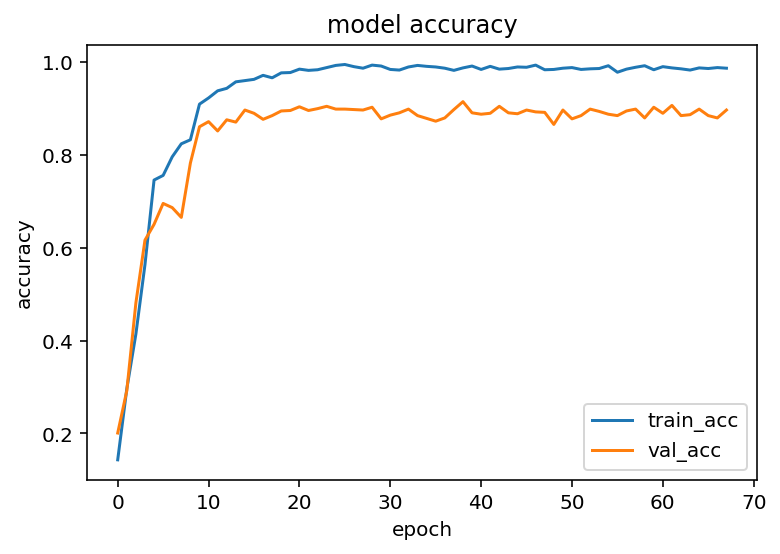

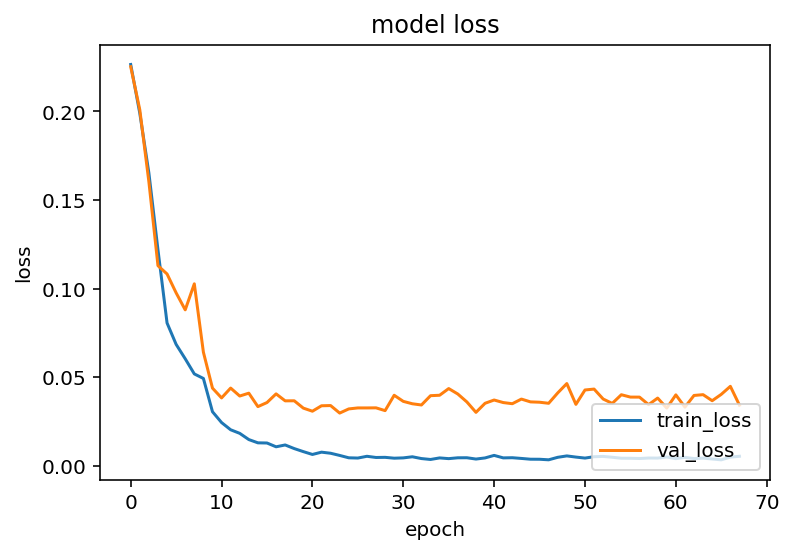

100%|██████████| 20/20 [00:02<00:00,  7.76it/s]
[2017-12-02 23:12:24,612 INFO] TestAcc: 0.9177 | TestLoss: 0.0271 
100%|██████████| 114/114 [00:14<00:00,  7.89it/s]
[2017-12-02 23:12:39,114 INFO] UnlabeledAcc: 0.9098 | UnlabeledLoss: 0.0306 
[2017-12-02 23:12:40,200 INFO] Epoch: 0 | TrainAcc: 0.1653 | TrainLoss: 0.2334
[2017-12-02 23:12:40,591 INFO] Epoch: 0 | ValAcc: 0.1000 | ValLoss: 0.2285 

[2017-12-02 23:12:41,669 INFO] Epoch: 1 | TrainAcc: 0.2373 | TrainLoss: 0.2108
[2017-12-02 23:12:42,133 INFO] Epoch: 1 | ValAcc: 0.2420 | ValLoss: 0.2068 

[2017-12-02 23:12:43,215 INFO] Epoch: 2 | TrainAcc: 0.3613 | TrainLoss: 0.1820
[2017-12-02 23:12:43,653 INFO] Epoch: 2 | ValAcc: 0.2840 | ValLoss: 0.1800 

[2017-12-02 23:12:44,636 INFO] Epoch: 3 | TrainAcc: 0.5153 | TrainLoss: 0.1394
[2017-12-02 23:12:45,037 INFO] Epoch: 3 | ValAcc: 0.5450 | ValLoss: 0.1373 

[2017-12-02 23:12:46,107 INFO] Epoch: 4 | TrainAcc: 0.7027 | TrainLoss: 0.0922
[2017-12-02 23:12:46,470 INFO] Epoch: 4 | ValAcc: 0.668

[2017-12-02 23:13:52,406 INFO] Epoch: 50 | ValAcc: 0.8610 | ValLoss: 0.0499 

[2017-12-02 23:13:53,403 INFO] Epoch: 51 | TrainAcc: 0.9880 | TrainLoss: 0.0045
[2017-12-02 23:13:53,758 INFO] Epoch: 51 | ValAcc: 0.8460 | ValLoss: 0.0504 

[2017-12-02 23:13:54,742 INFO] Epoch: 52 | TrainAcc: 0.9847 | TrainLoss: 0.0043
[2017-12-02 23:13:55,100 INFO] Epoch: 52 | ValAcc: 0.8750 | ValLoss: 0.0425 

[2017-12-02 23:13:56,093 INFO] Epoch: 53 | TrainAcc: 0.9827 | TrainLoss: 0.0053
[2017-12-02 23:13:56,451 INFO] Epoch: 53 | ValAcc: 0.8760 | ValLoss: 0.0485 

[2017-12-02 23:13:57,443 INFO] Epoch: 54 | TrainAcc: 0.9887 | TrainLoss: 0.0041
[2017-12-02 23:13:57,809 INFO] Epoch: 54 | ValAcc: 0.8760 | ValLoss: 0.0450 

[2017-12-02 23:13:58,795 INFO] Epoch: 55 | TrainAcc: 0.9880 | TrainLoss: 0.0046
[2017-12-02 23:13:59,151 INFO] Epoch: 55 | ValAcc: 0.8600 | ValLoss: 0.0497 

[2017-12-02 23:14:00,220 INFO] Epoch: 56 | TrainAcc: 0.9840 | TrainLoss: 0.0055
[2017-12-02 23:14:00,597 INFO] Epoch: 56 | ValAcc: 0

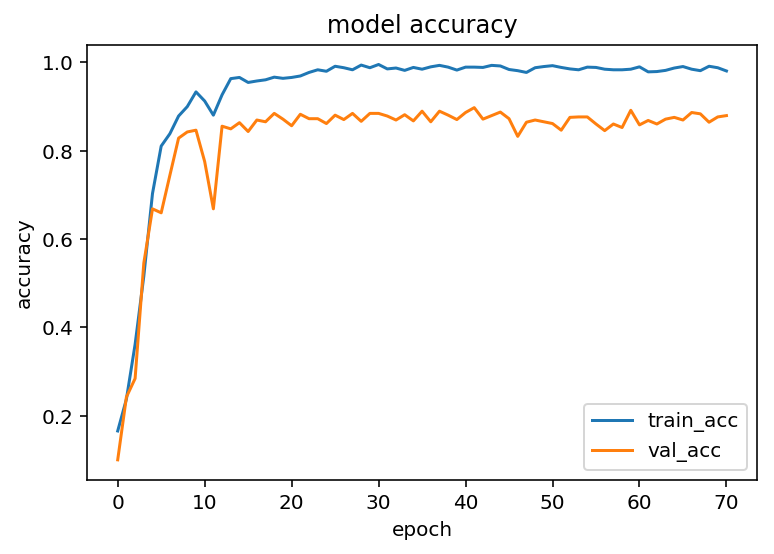

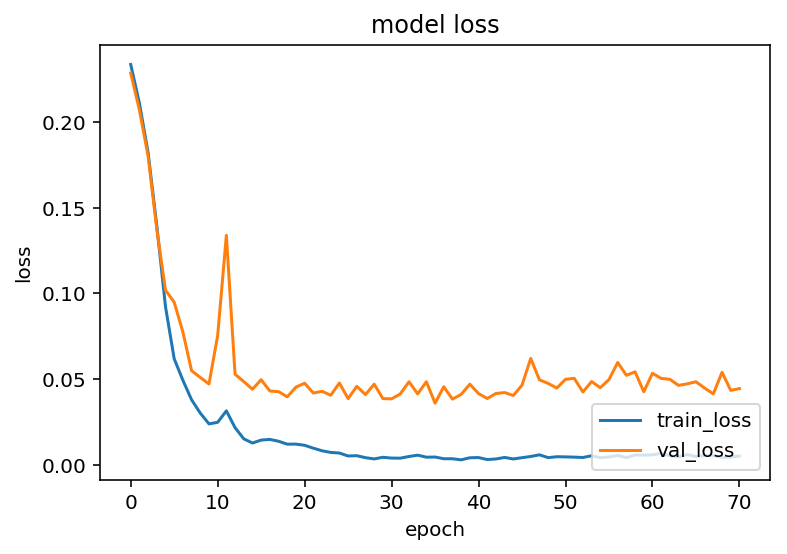

100%|██████████| 20/20 [00:02<00:00,  7.17it/s]
[2017-12-02 23:14:25,058 INFO] TestAcc: 0.8977 | TestLoss: 0.0350 
100%|██████████| 114/114 [00:13<00:00,  8.16it/s]
[2017-12-02 23:14:39,105 INFO] UnlabeledAcc: 0.8903 | UnlabeledLoss: 0.0383 
[2017-12-02 23:14:40,060 INFO] Epoch: 0 | TrainAcc: 0.1407 | TrainLoss: 0.2310
[2017-12-02 23:14:40,447 INFO] Epoch: 0 | ValAcc: 0.1830 | ValLoss: 0.2272 

[2017-12-02 23:14:41,612 INFO] Epoch: 1 | TrainAcc: 0.2640 | TrainLoss: 0.2053
[2017-12-02 23:14:42,025 INFO] Epoch: 1 | ValAcc: 0.2680 | ValLoss: 0.2052 

[2017-12-02 23:14:43,010 INFO] Epoch: 2 | TrainAcc: 0.3860 | TrainLoss: 0.1716
[2017-12-02 23:14:43,362 INFO] Epoch: 2 | ValAcc: 0.4070 | ValLoss: 0.1660 

[2017-12-02 23:14:44,319 INFO] Epoch: 3 | TrainAcc: 0.6047 | TrainLoss: 0.1213
[2017-12-02 23:14:44,703 INFO] Epoch: 3 | ValAcc: 0.5960 | ValLoss: 0.1173 

[2017-12-02 23:14:45,730 INFO] Epoch: 4 | TrainAcc: 0.7160 | TrainLoss: 0.0839
[2017-12-02 23:14:46,127 INFO] Epoch: 4 | ValAcc: 0.566

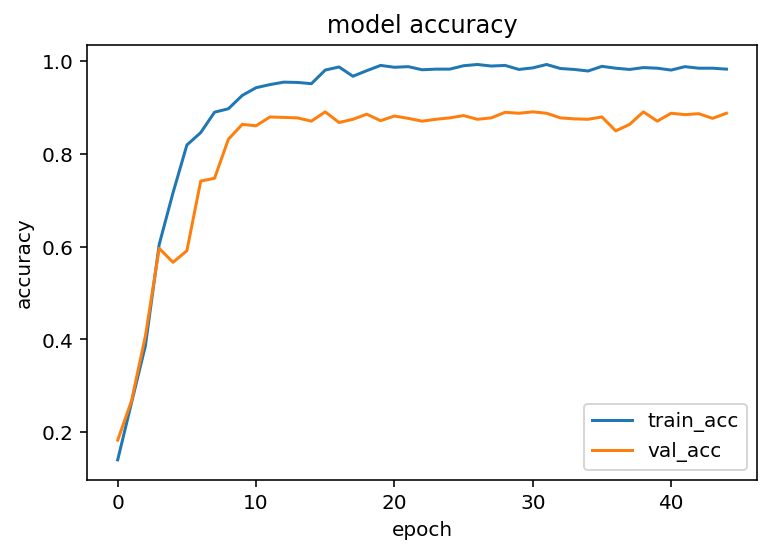

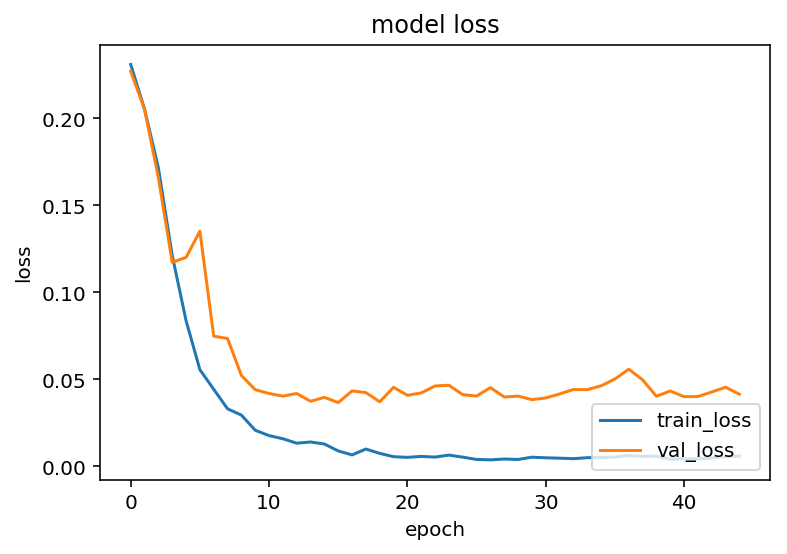

100%|██████████| 20/20 [00:02<00:00,  7.09it/s]
[2017-12-02 23:15:47,601 INFO] TestAcc: 0.9050 | TestLoss: 0.0303 
100%|██████████| 114/114 [00:14<00:00,  8.13it/s]
[2017-12-02 23:16:01,684 INFO] UnlabeledAcc: 0.8963 | UnlabeledLoss: 0.0335 
[2017-12-02 23:16:02,871 INFO] Epoch: 0 | TrainAcc: 0.1927 | TrainLoss: 0.2178
[2017-12-02 23:16:03,226 INFO] Epoch: 0 | ValAcc: 0.1830 | ValLoss: 0.2218 

[2017-12-02 23:16:04,212 INFO] Epoch: 1 | TrainAcc: 0.3773 | TrainLoss: 0.1732
[2017-12-02 23:16:04,568 INFO] Epoch: 1 | ValAcc: 0.3420 | ValLoss: 0.1812 

[2017-12-02 23:16:05,526 INFO] Epoch: 2 | TrainAcc: 0.5940 | TrainLoss: 0.1202
[2017-12-02 23:16:05,898 INFO] Epoch: 2 | ValAcc: 0.3330 | ValLoss: 0.1878 

[2017-12-02 23:16:06,863 INFO] Epoch: 3 | TrainAcc: 0.6913 | TrainLoss: 0.0855
[2017-12-02 23:16:07,216 INFO] Epoch: 3 | ValAcc: 0.5440 | ValLoss: 0.1492 

[2017-12-02 23:16:08,194 INFO] Epoch: 4 | TrainAcc: 0.7887 | TrainLoss: 0.0595
[2017-12-02 23:16:08,541 INFO] Epoch: 4 | ValAcc: 0.736

[2017-12-02 23:17:17,336 INFO] Epoch: 50 | ValAcc: 0.8640 | ValLoss: 0.0469 

[2017-12-02 23:17:18,560 INFO] Epoch: 51 | TrainAcc: 0.9880 | TrainLoss: 0.0045
[2017-12-02 23:17:19,048 INFO] Epoch: 51 | ValAcc: 0.8850 | ValLoss: 0.0422 

[2017-12-02 23:17:20,239 INFO] Epoch: 52 | TrainAcc: 0.9873 | TrainLoss: 0.0043
[2017-12-02 23:17:20,679 INFO] Epoch: 52 | ValAcc: 0.8950 | ValLoss: 0.0373 

[2017-12-02 23:17:21,863 INFO] Epoch: 53 | TrainAcc: 0.9827 | TrainLoss: 0.0039
[2017-12-02 23:17:22,333 INFO] Epoch: 53 | ValAcc: 0.8870 | ValLoss: 0.0446 

[2017-12-02 23:17:23,450 INFO] Epoch: 54 | TrainAcc: 0.9893 | TrainLoss: 0.0041
[2017-12-02 23:17:23,887 INFO] Epoch: 54 | ValAcc: 0.8970 | ValLoss: 0.0376 

[2017-12-02 23:17:25,036 INFO] Epoch: 55 | TrainAcc: 0.9873 | TrainLoss: 0.0038
[2017-12-02 23:17:25,398 INFO] Epoch: 55 | ValAcc: 0.8670 | ValLoss: 0.0454 

[2017-12-02 23:17:26,463 INFO] Epoch: 56 | TrainAcc: 0.9880 | TrainLoss: 0.0042
[2017-12-02 23:17:26,845 INFO] Epoch: 56 | ValAcc: 0

[2017-12-02 23:18:34,760 INFO] Epoch: 102 | ValAcc: 0.8930 | ValLoss: 0.0388 

[2017-12-02 23:18:36,038 INFO] Epoch: 103 | TrainAcc: 0.9873 | TrainLoss: 0.0036
[2017-12-02 23:18:36,510 INFO] Epoch: 103 | ValAcc: 0.8840 | ValLoss: 0.0383 

[2017-12-02 23:18:37,776 INFO] Epoch: 104 | TrainAcc: 0.9840 | TrainLoss: 0.0036
[2017-12-02 23:18:38,165 INFO] Epoch: 104 | ValAcc: 0.8960 | ValLoss: 0.0380 

[2017-12-02 23:18:39,193 INFO] Epoch: 105 | TrainAcc: 0.9773 | TrainLoss: 0.0051
[2017-12-02 23:18:39,549 INFO] Epoch: 105 | ValAcc: 0.9100 | ValLoss: 0.0344 

[2017-12-02 23:18:40,525 INFO] Epoch: 106 | TrainAcc: 0.9847 | TrainLoss: 0.0037
[2017-12-02 23:18:40,877 INFO] Epoch: 106 | ValAcc: 0.8760 | ValLoss: 0.0438 

[2017-12-02 23:18:42,033 INFO] Epoch: 107 | TrainAcc: 0.9900 | TrainLoss: 0.0043
[2017-12-02 23:18:42,392 INFO] Epoch: 107 | ValAcc: 0.8660 | ValLoss: 0.0436 

[2017-12-02 23:18:43,544 INFO] Epoch: 108 | TrainAcc: 0.9780 | TrainLoss: 0.0048
[2017-12-02 23:18:44,006 INFO] Epoch: 10

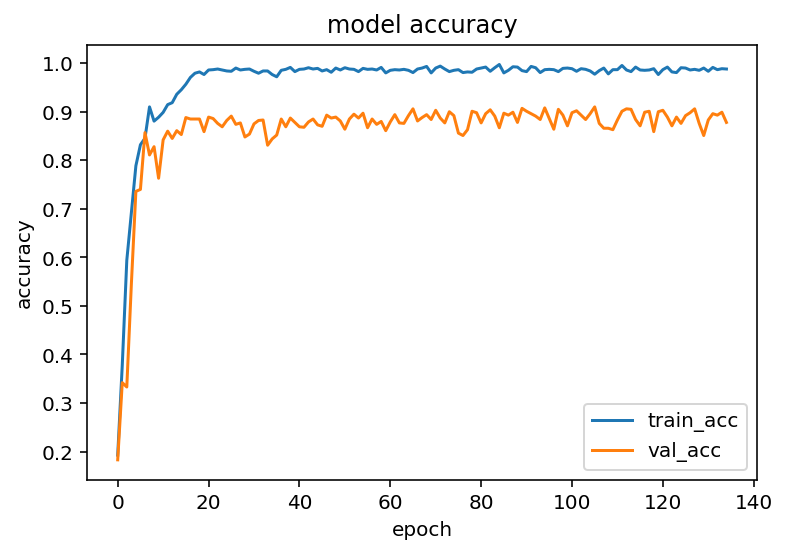

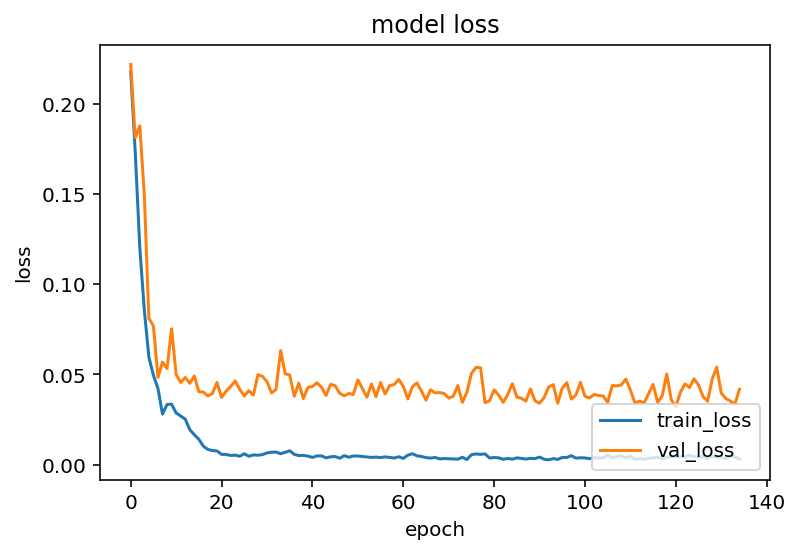

100%|██████████| 20/20 [00:02<00:00,  7.36it/s]
[2017-12-02 23:19:23,426 INFO] TestAcc: 0.9145 | TestLoss: 0.0306 
100%|██████████| 114/114 [00:14<00:00,  7.81it/s]
[2017-12-02 23:19:38,092 INFO] UnlabeledAcc: 0.9032 | UnlabeledLoss: 0.0340 
[2017-12-02 23:19:39,063 INFO] Epoch: 0 | TrainAcc: 0.1467 | TrainLoss: 0.2308
[2017-12-02 23:19:39,450 INFO] Epoch: 0 | ValAcc: 0.1170 | ValLoss: 0.2250 

[2017-12-02 23:19:40,429 INFO] Epoch: 1 | TrainAcc: 0.3353 | TrainLoss: 0.1930
[2017-12-02 23:19:40,781 INFO] Epoch: 1 | ValAcc: 0.3090 | ValLoss: 0.1930 

[2017-12-02 23:19:41,935 INFO] Epoch: 2 | TrainAcc: 0.5573 | TrainLoss: 0.1414
[2017-12-02 23:19:42,365 INFO] Epoch: 2 | ValAcc: 0.4900 | ValLoss: 0.1462 

[2017-12-02 23:19:43,438 INFO] Epoch: 3 | TrainAcc: 0.6747 | TrainLoss: 0.0968
[2017-12-02 23:19:43,790 INFO] Epoch: 3 | ValAcc: 0.4360 | ValLoss: 0.1605 

[2017-12-02 23:19:44,755 INFO] Epoch: 4 | TrainAcc: 0.7333 | TrainLoss: 0.0766
[2017-12-02 23:19:45,114 INFO] Epoch: 4 | ValAcc: 0.722

[2017-12-02 23:20:50,390 INFO] Epoch: 50 | ValAcc: 0.9020 | ValLoss: 0.0338 

[2017-12-02 23:20:51,362 INFO] Epoch: 51 | TrainAcc: 0.9853 | TrainLoss: 0.0050
[2017-12-02 23:20:51,723 INFO] Epoch: 51 | ValAcc: 0.9020 | ValLoss: 0.0380 

[2017-12-02 23:20:52,688 INFO] Epoch: 52 | TrainAcc: 0.9860 | TrainLoss: 0.0048
[2017-12-02 23:20:53,028 INFO] Epoch: 52 | ValAcc: 0.8940 | ValLoss: 0.0374 

[2017-12-02 23:20:54,012 INFO] Epoch: 53 | TrainAcc: 0.9833 | TrainLoss: 0.0048
[2017-12-02 23:20:54,352 INFO] Epoch: 53 | ValAcc: 0.8600 | ValLoss: 0.0481 

[2017-12-02 23:20:55,307 INFO] Epoch: 54 | TrainAcc: 0.9847 | TrainLoss: 0.0046
[2017-12-02 23:20:55,688 INFO] Epoch: 54 | ValAcc: 0.8850 | ValLoss: 0.0377 

[2017-12-02 23:20:56,677 INFO] Epoch: 55 | TrainAcc: 0.9853 | TrainLoss: 0.0055
[2017-12-02 23:20:57,033 INFO] Epoch: 55 | ValAcc: 0.8830 | ValLoss: 0.0402 

[2017-12-02 23:20:58,017 INFO] Epoch: 56 | TrainAcc: 0.9840 | TrainLoss: 0.0043
[2017-12-02 23:20:58,379 INFO] Epoch: 56 | ValAcc: 0

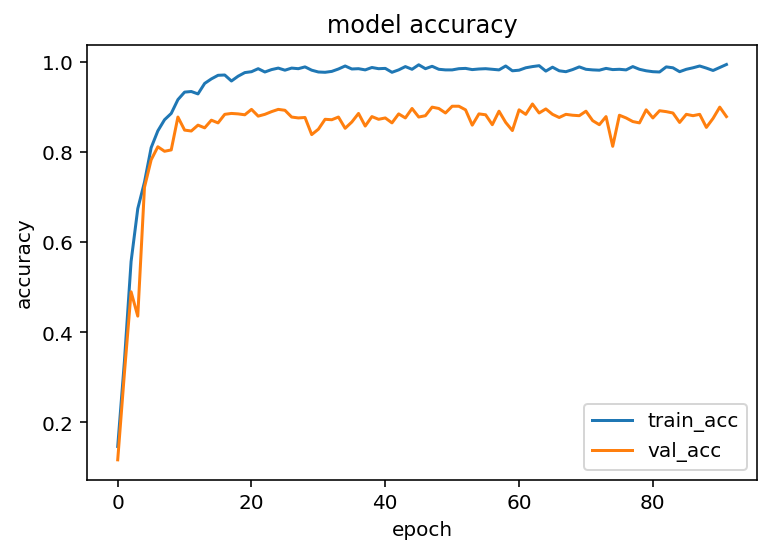

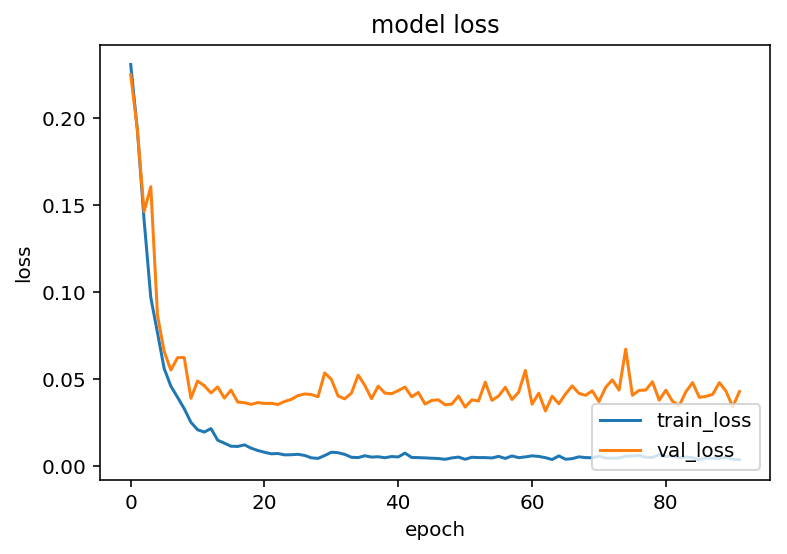

100%|██████████| 20/20 [00:02<00:00,  8.29it/s]
[2017-12-02 23:21:47,307 INFO] TestAcc: 0.9159 | TestLoss: 0.0275 
100%|██████████| 114/114 [00:12<00:00,  9.47it/s]
[2017-12-02 23:21:59,393 INFO] UnlabeledAcc: 0.9102 | UnlabeledLoss: 0.0303 
[2017-12-02 23:22:00,328 INFO] Epoch: 0 | TrainAcc: 0.1153 | TrainLoss: 0.2664
[2017-12-02 23:22:00,686 INFO] Epoch: 0 | ValAcc: 0.1000 | ValLoss: 0.2347 

[2017-12-02 23:22:01,665 INFO] Epoch: 1 | TrainAcc: 0.1147 | TrainLoss: 0.2257
[2017-12-02 23:22:02,032 INFO] Epoch: 1 | ValAcc: 0.1000 | ValLoss: 0.2287 

[2017-12-02 23:22:02,966 INFO] Epoch: 2 | TrainAcc: 0.1953 | TrainLoss: 0.2190
[2017-12-02 23:22:03,311 INFO] Epoch: 2 | ValAcc: 0.2680 | ValLoss: 0.2239 

[2017-12-02 23:22:04,285 INFO] Epoch: 3 | TrainAcc: 0.2127 | TrainLoss: 0.2111
[2017-12-02 23:22:04,629 INFO] Epoch: 3 | ValAcc: 0.2320 | ValLoss: 0.2114 

[2017-12-02 23:22:05,597 INFO] Epoch: 4 | TrainAcc: 0.3140 | TrainLoss: 0.1924
[2017-12-02 23:22:05,942 INFO] Epoch: 4 | ValAcc: 0.190

[2017-12-02 23:23:07,066 INFO] Epoch: 50 | ValAcc: 0.8450 | ValLoss: 0.0578 

[2017-12-02 23:23:08,021 INFO] Epoch: 51 | TrainAcc: 0.9813 | TrainLoss: 0.0065
[2017-12-02 23:23:08,374 INFO] Epoch: 51 | ValAcc: 0.8570 | ValLoss: 0.0528 

[2017-12-02 23:23:09,341 INFO] Epoch: 52 | TrainAcc: 0.9847 | TrainLoss: 0.0052
[2017-12-02 23:23:09,687 INFO] Epoch: 52 | ValAcc: 0.8680 | ValLoss: 0.0468 

[2017-12-02 23:23:10,644 INFO] Epoch: 53 | TrainAcc: 0.9867 | TrainLoss: 0.0058
[2017-12-02 23:23:10,990 INFO] Epoch: 53 | ValAcc: 0.8590 | ValLoss: 0.0510 

[2017-12-02 23:23:11,979 INFO] Epoch: 54 | TrainAcc: 0.9867 | TrainLoss: 0.0052
[2017-12-02 23:23:12,336 INFO] Epoch: 54 | ValAcc: 0.8730 | ValLoss: 0.0469 

[2017-12-02 23:23:13,295 INFO] Epoch: 55 | TrainAcc: 0.9860 | TrainLoss: 0.0055
[2017-12-02 23:23:13,634 INFO] Epoch: 55 | ValAcc: 0.8550 | ValLoss: 0.0565 

[2017-12-02 23:23:14,624 INFO] Epoch: 56 | TrainAcc: 0.9867 | TrainLoss: 0.0043
[2017-12-02 23:23:14,979 INFO] Epoch: 56 | ValAcc: 0

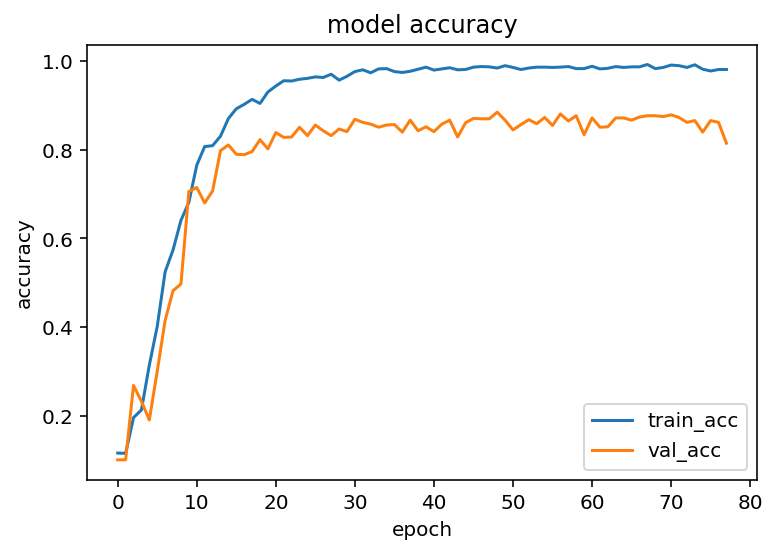

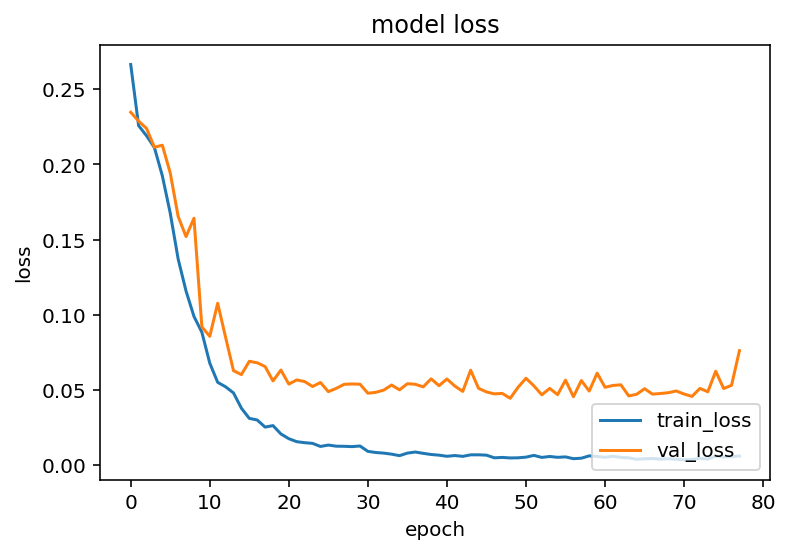

100%|██████████| 20/20 [00:02<00:00,  9.47it/s]
[2017-12-02 23:23:45,117 INFO] TestAcc: 0.8853 | TestLoss: 0.0405 
100%|██████████| 114/114 [00:11<00:00,  9.70it/s]
[2017-12-02 23:23:56,913 INFO] UnlabeledAcc: 0.8762 | UnlabeledLoss: 0.0440 
[2017-12-02 23:23:57,832 INFO] Epoch: 0 | TrainAcc: 0.1500 | TrainLoss: 0.2404
[2017-12-02 23:23:58,190 INFO] Epoch: 0 | ValAcc: 0.1750 | ValLoss: 0.2287 

[2017-12-02 23:23:59,150 INFO] Epoch: 1 | TrainAcc: 0.1900 | TrainLoss: 0.2140
[2017-12-02 23:23:59,488 INFO] Epoch: 1 | ValAcc: 0.2730 | ValLoss: 0.2139 

[2017-12-02 23:24:00,435 INFO] Epoch: 2 | TrainAcc: 0.3687 | TrainLoss: 0.1803
[2017-12-02 23:24:00,785 INFO] Epoch: 2 | ValAcc: 0.4500 | ValLoss: 0.1709 

[2017-12-02 23:24:01,728 INFO] Epoch: 3 | TrainAcc: 0.5627 | TrainLoss: 0.1321
[2017-12-02 23:24:02,078 INFO] Epoch: 3 | ValAcc: 0.5590 | ValLoss: 0.1283 

[2017-12-02 23:24:03,025 INFO] Epoch: 4 | TrainAcc: 0.6793 | TrainLoss: 0.1000
[2017-12-02 23:24:03,371 INFO] Epoch: 4 | ValAcc: 0.631

[2017-12-02 23:25:03,078 INFO] Epoch: 50 | ValAcc: 0.8590 | ValLoss: 0.0504 

[2017-12-02 23:25:04,029 INFO] Epoch: 51 | TrainAcc: 0.9873 | TrainLoss: 0.0043
[2017-12-02 23:25:04,372 INFO] Epoch: 51 | ValAcc: 0.8710 | ValLoss: 0.0436 

[2017-12-02 23:25:05,308 INFO] Epoch: 52 | TrainAcc: 0.9907 | TrainLoss: 0.0038
[2017-12-02 23:25:05,646 INFO] Epoch: 52 | ValAcc: 0.8680 | ValLoss: 0.0459 

[2017-12-02 23:25:06,574 INFO] Epoch: 53 | TrainAcc: 0.9873 | TrainLoss: 0.0037
[2017-12-02 23:25:06,919 INFO] Epoch: 53 | ValAcc: 0.8650 | ValLoss: 0.0442 

[2017-12-02 23:25:07,871 INFO] Epoch: 54 | TrainAcc: 0.9907 | TrainLoss: 0.0047
[2017-12-02 23:25:08,227 INFO] Epoch: 54 | ValAcc: 0.8440 | ValLoss: 0.0512 

[2017-12-02 23:25:09,151 INFO] Epoch: 55 | TrainAcc: 0.9867 | TrainLoss: 0.0046
[2017-12-02 23:25:09,501 INFO] Epoch: 55 | ValAcc: 0.8650 | ValLoss: 0.0448 

[2017-12-02 23:25:10,427 INFO] Epoch: 56 | TrainAcc: 0.9847 | TrainLoss: 0.0051
[2017-12-02 23:25:10,769 INFO] Epoch: 56 | ValAcc: 0

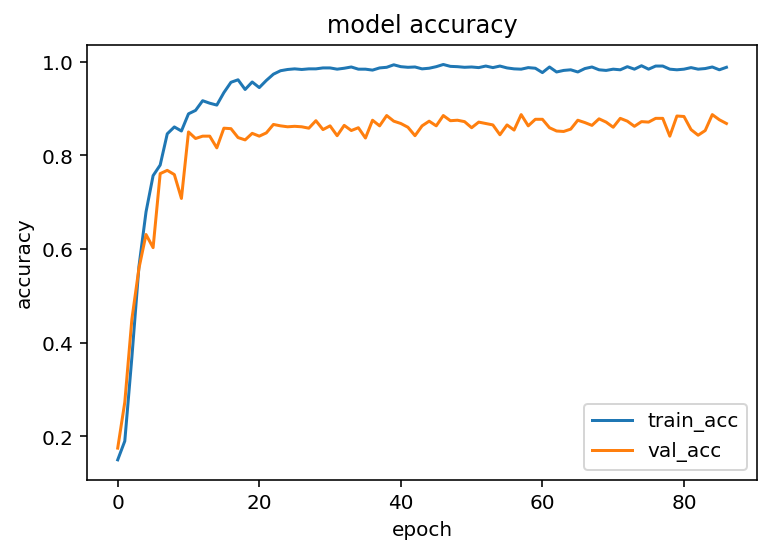

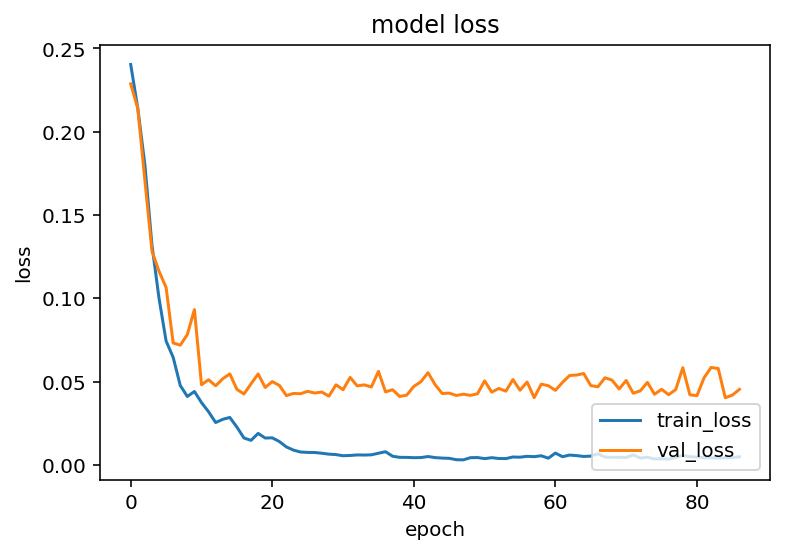

100%|██████████| 20/20 [00:02<00:00,  8.94it/s]
[2017-12-02 23:25:52,625 INFO] TestAcc: 0.8905 | TestLoss: 0.0373 
100%|██████████| 114/114 [00:11<00:00,  9.77it/s]
[2017-12-02 23:26:04,343 INFO] UnlabeledAcc: 0.8829 | UnlabeledLoss: 0.0420 
[2017-12-02 23:26:05,274 INFO] Epoch: 0 | TrainAcc: 0.1467 | TrainLoss: 0.2252
[2017-12-02 23:26:05,625 INFO] Epoch: 0 | ValAcc: 0.1990 | ValLoss: 0.2263 

[2017-12-02 23:26:06,620 INFO] Epoch: 1 | TrainAcc: 0.3133 | TrainLoss: 0.1967
[2017-12-02 23:26:06,971 INFO] Epoch: 1 | ValAcc: 0.3460 | ValLoss: 0.1911 

[2017-12-02 23:26:07,923 INFO] Epoch: 2 | TrainAcc: 0.5187 | TrainLoss: 0.1392
[2017-12-02 23:26:08,282 INFO] Epoch: 2 | ValAcc: 0.3020 | ValLoss: 0.2074 

[2017-12-02 23:26:09,252 INFO] Epoch: 3 | TrainAcc: 0.6967 | TrainLoss: 0.0921
[2017-12-02 23:26:09,584 INFO] Epoch: 3 | ValAcc: 0.6010 | ValLoss: 0.1031 

[2017-12-02 23:26:10,554 INFO] Epoch: 4 | TrainAcc: 0.7873 | TrainLoss: 0.0632
[2017-12-02 23:26:10,907 INFO] Epoch: 4 | ValAcc: 0.708

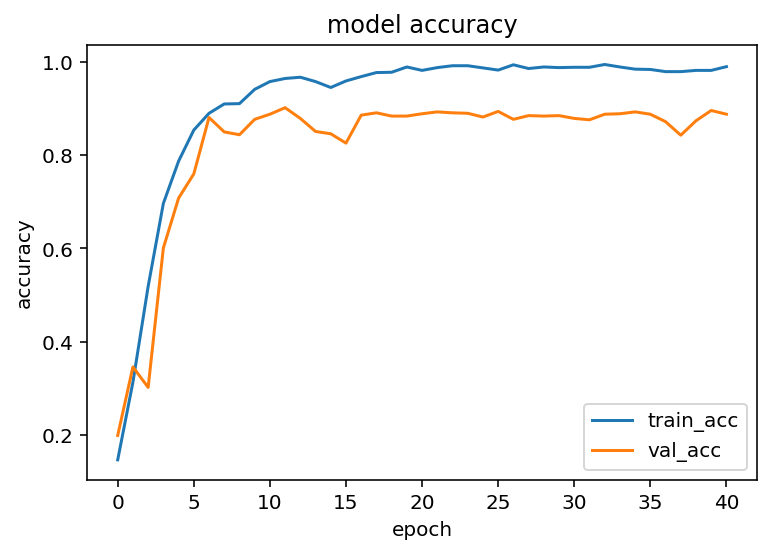

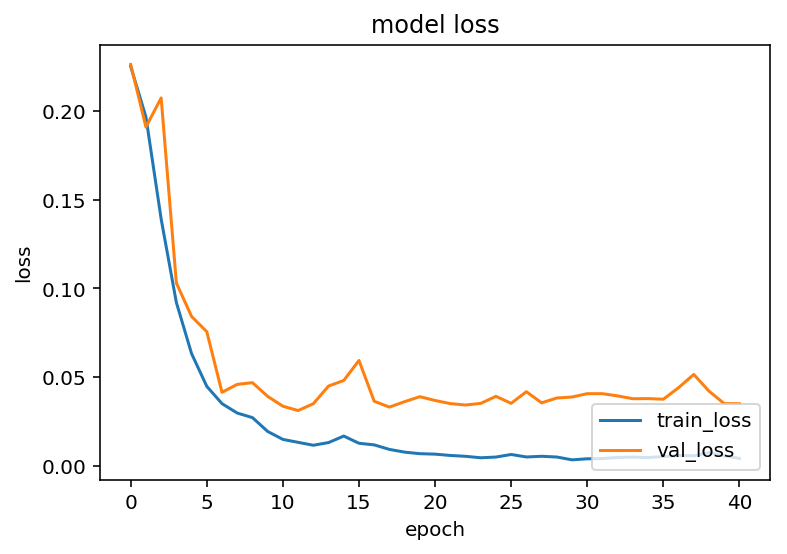

100%|██████████| 20/20 [00:02<00:00,  8.84it/s]
[2017-12-02 23:27:00,498 INFO] TestAcc: 0.8928 | TestLoss: 0.0345 
100%|██████████| 114/114 [00:11<00:00,  9.81it/s]
[2017-12-02 23:27:12,173 INFO] UnlabeledAcc: 0.8911 | UnlabeledLoss: 0.0347 
[2017-12-02 23:27:13,133 INFO] Epoch: 0 | TrainAcc: 0.1153 | TrainLoss: 0.2306
[2017-12-02 23:27:13,488 INFO] Epoch: 0 | ValAcc: 0.1840 | ValLoss: 0.2260 

[2017-12-02 23:27:14,443 INFO] Epoch: 1 | TrainAcc: 0.2733 | TrainLoss: 0.2000
[2017-12-02 23:27:14,791 INFO] Epoch: 1 | ValAcc: 0.3080 | ValLoss: 0.1922 

[2017-12-02 23:27:15,728 INFO] Epoch: 2 | TrainAcc: 0.4720 | TrainLoss: 0.1545
[2017-12-02 23:27:16,073 INFO] Epoch: 2 | ValAcc: 0.6050 | ValLoss: 0.1330 

[2017-12-02 23:27:17,007 INFO] Epoch: 3 | TrainAcc: 0.6587 | TrainLoss: 0.1026
[2017-12-02 23:27:17,361 INFO] Epoch: 3 | ValAcc: 0.7380 | ValLoss: 0.0857 

[2017-12-02 23:27:18,329 INFO] Epoch: 4 | TrainAcc: 0.7780 | TrainLoss: 0.0706
[2017-12-02 23:27:18,676 INFO] Epoch: 4 | ValAcc: 0.726

[2017-12-02 23:28:18,904 INFO] Epoch: 50 | ValAcc: 0.8710 | ValLoss: 0.0465 

[2017-12-02 23:28:19,889 INFO] Epoch: 51 | TrainAcc: 0.9760 | TrainLoss: 0.0067
[2017-12-02 23:28:20,248 INFO] Epoch: 51 | ValAcc: 0.8740 | ValLoss: 0.0470 

[2017-12-02 23:28:21,197 INFO] Epoch: 52 | TrainAcc: 0.9800 | TrainLoss: 0.0052
[2017-12-02 23:28:21,541 INFO] Epoch: 52 | ValAcc: 0.8790 | ValLoss: 0.0461 

[2017-12-02 23:28:22,466 INFO] Epoch: 53 | TrainAcc: 0.9847 | TrainLoss: 0.0048
[2017-12-02 23:28:22,805 INFO] Epoch: 53 | ValAcc: 0.8700 | ValLoss: 0.0474 

[2017-12-02 23:28:23,775 INFO] Epoch: 54 | TrainAcc: 0.9920 | TrainLoss: 0.0042
[2017-12-02 23:28:24,127 INFO] Epoch: 54 | ValAcc: 0.8810 | ValLoss: 0.0411 

[2017-12-02 23:28:25,095 INFO] Epoch: 55 | TrainAcc: 0.9827 | TrainLoss: 0.0042
[2017-12-02 23:28:25,452 INFO] Epoch: 55 | ValAcc: 0.9040 | ValLoss: 0.0360 

[2017-12-02 23:28:26,423 INFO] Epoch: 56 | TrainAcc: 0.9893 | TrainLoss: 0.0039
[2017-12-02 23:28:26,764 INFO] Epoch: 56 | ValAcc: 0

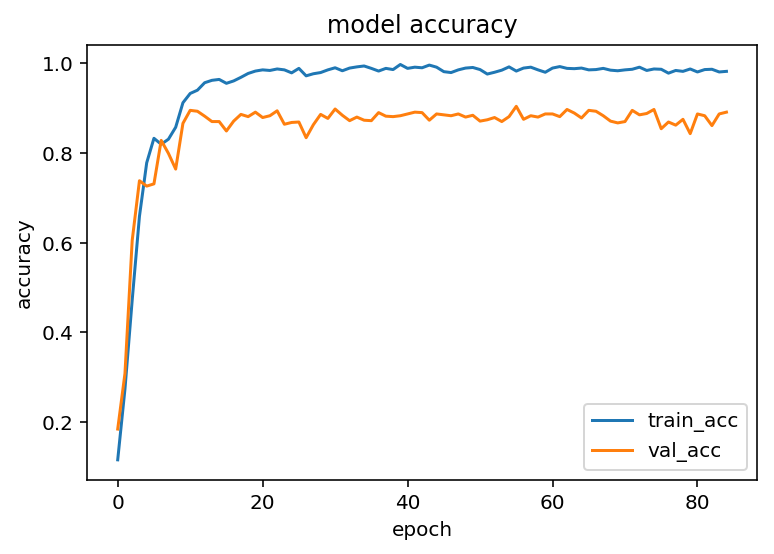

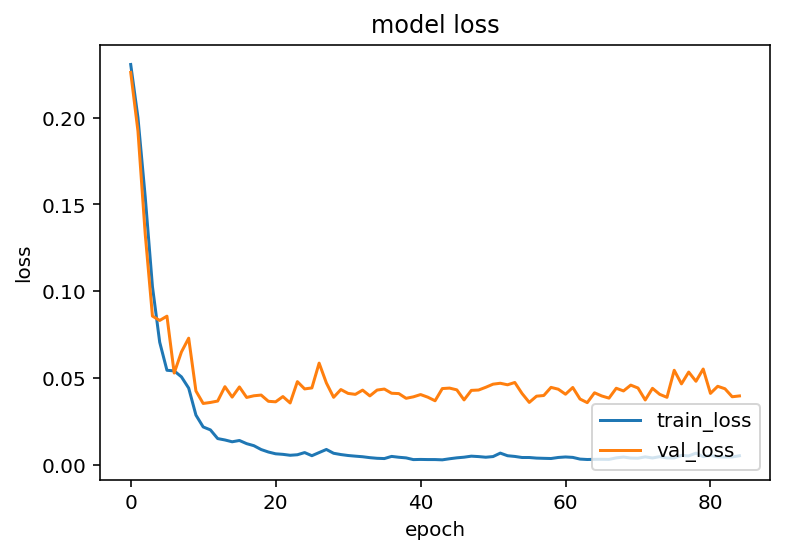

100%|██████████| 20/20 [00:02<00:00,  8.79it/s]
[2017-12-02 23:29:05,713 INFO] TestAcc: 0.9049 | TestLoss: 0.0330 
100%|██████████| 114/114 [00:11<00:00,  9.67it/s]
[2017-12-02 23:29:17,556 INFO] UnlabeledAcc: 0.9009 | UnlabeledLoss: 0.0343 
[2017-12-02 23:29:18,495 INFO] Epoch: 0 | TrainAcc: 0.1613 | TrainLoss: 0.2379
[2017-12-02 23:29:18,839 INFO] Epoch: 0 | ValAcc: 0.1760 | ValLoss: 0.2278 

[2017-12-02 23:29:19,798 INFO] Epoch: 1 | TrainAcc: 0.2233 | TrainLoss: 0.2136
[2017-12-02 23:29:20,138 INFO] Epoch: 1 | ValAcc: 0.3150 | ValLoss: 0.2097 

[2017-12-02 23:29:21,078 INFO] Epoch: 2 | TrainAcc: 0.3980 | TrainLoss: 0.1796
[2017-12-02 23:29:21,430 INFO] Epoch: 2 | ValAcc: 0.3220 | ValLoss: 0.1871 

[2017-12-02 23:29:22,369 INFO] Epoch: 3 | TrainAcc: 0.4960 | TrainLoss: 0.1408
[2017-12-02 23:29:22,704 INFO] Epoch: 3 | ValAcc: 0.3100 | ValLoss: 0.2514 

[2017-12-02 23:29:23,659 INFO] Epoch: 4 | TrainAcc: 0.6173 | TrainLoss: 0.1096
[2017-12-02 23:29:24,010 INFO] Epoch: 4 | ValAcc: 0.530

[2017-12-02 23:30:23,755 INFO] Epoch: 50 | ValAcc: 0.8660 | ValLoss: 0.0511 

[2017-12-02 23:30:24,715 INFO] Epoch: 51 | TrainAcc: 0.9827 | TrainLoss: 0.0061
[2017-12-02 23:30:25,076 INFO] Epoch: 51 | ValAcc: 0.8550 | ValLoss: 0.0513 

[2017-12-02 23:30:26,032 INFO] Epoch: 52 | TrainAcc: 0.9847 | TrainLoss: 0.0048
[2017-12-02 23:30:26,370 INFO] Epoch: 52 | ValAcc: 0.8670 | ValLoss: 0.0466 

[2017-12-02 23:30:27,315 INFO] Epoch: 53 | TrainAcc: 0.9900 | TrainLoss: 0.0036
[2017-12-02 23:30:27,655 INFO] Epoch: 53 | ValAcc: 0.8840 | ValLoss: 0.0403 

[2017-12-02 23:30:28,632 INFO] Epoch: 54 | TrainAcc: 0.9860 | TrainLoss: 0.0042
[2017-12-02 23:30:28,997 INFO] Epoch: 54 | ValAcc: 0.8890 | ValLoss: 0.0393 

[2017-12-02 23:30:29,953 INFO] Epoch: 55 | TrainAcc: 0.9913 | TrainLoss: 0.0038
[2017-12-02 23:30:30,293 INFO] Epoch: 55 | ValAcc: 0.8990 | ValLoss: 0.0380 

[2017-12-02 23:30:31,255 INFO] Epoch: 56 | TrainAcc: 0.9853 | TrainLoss: 0.0046
[2017-12-02 23:30:31,607 INFO] Epoch: 56 | ValAcc: 0

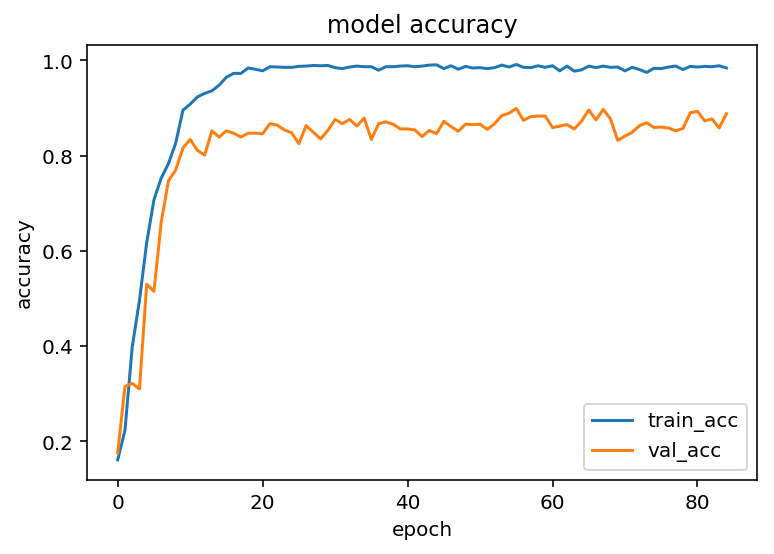

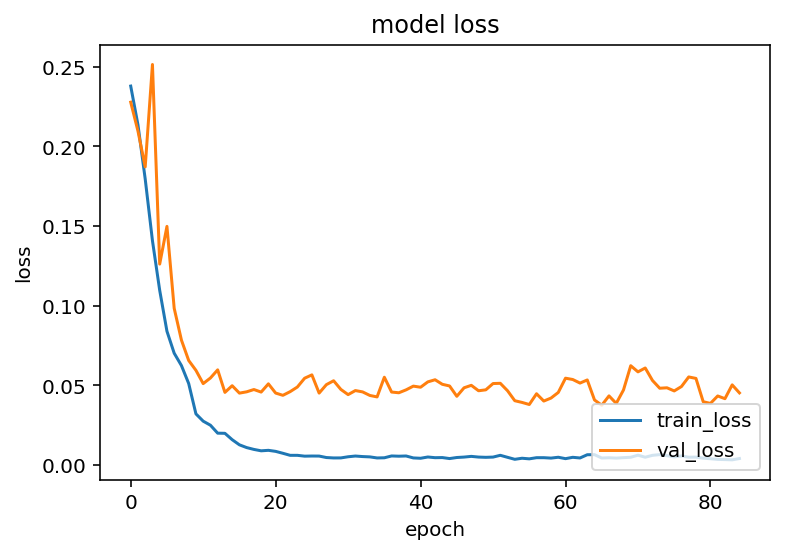

100%|██████████| 20/20 [00:02<00:00,  9.01it/s]
[2017-12-02 23:31:10,861 INFO] TestAcc: 0.9006 | TestLoss: 0.0345 
100%|██████████| 114/114 [00:11<00:00,  9.71it/s]
[2017-12-02 23:31:22,656 INFO] UnlabeledAcc: 0.8914 | UnlabeledLoss: 0.0379 


In [28]:
# set experimental params
epochs = 1000
lr = 0.5
momentum = 0.9
ratio_pl = 1.0 # ratio of train:pseudo
hard = False
ex_name = 'pseudo_soft'
trial_times = 30

logzero.logfile('./log/{}.log'.format(ex_name))

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

results_soft = {}
results_soft['test_acc'] = np.empty((trial_times))
results_soft['test_loss'] = np.empty((trial_times))
results_soft['unlabeled_acc'] = np.empty((trial_times))
results_soft['unlabeled_loss'] = np.empty((trial_times))
for i in range(trial_times):
    train_dataset = MNISTDatasetForPseudoLabeling(
        X_train, y_train, X_unlabeled, y_pseudo, ratio_pl, hard, transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_dataset = MNISTDataset(X_val, y_val, transform)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=test_batch_size, num_workers=num_workers)
    test_dataset = MNISTDataset(X_test, y_test, transform)
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, num_workers=num_workers)
    unlabeled_dataset = MNISTDataset(X_unlabeled, y_unlabeled, transform)
    unlabeled_loader = torch.utils.data.DataLoader(
        unlabeled_dataset, batch_size=test_batch_size, num_workers=num_workers)

    model = Net()
    if use_gpu:
        model.cuda()

    def save_checkpoint(state, filename='./save/checkpoint_{}.pth'.format(ex_name)):
        torch.save(state, filename)

    criterion = nn.KLDivLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    tracker = TrainingTracker()

    start = time.time()

    for epoch in range(0, epochs):
        tracker.epoch = epoch

        _train(model, train_loader, criterion, optimizer, tracker)
        _validate(model, val_loader, criterion, tracker)

        # if latest accuracy is the best in history
        if len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) == 1:
            save_checkpoint({
                'epoch': epoch,
                'state_dict': model.state_dict(),
                'optimizer' : optimizer.state_dict(),
            })
        elif len(tracker.history['val_acc']) - np.argmax(tracker.history['val_acc']) >= 30:
            logger.info('Accuracy dose not improve for a long epochs')
            break

    logger.info('Train done.')
    logger.info('Elapsed Time: {}'.format(time.time() - start))
    tracker.plot_history()
    
    model = Net()
    resume = torch.load('./save/checkpoint_{}.pth'.format(ex_name))
    model.load_state_dict(resume['state_dict'])
    results_soft['test_acc'][i], results_soft['test_loss'][i] = _test(model, test_loader, criterion)
    results_soft['unlabeled_acc'][i], results_soft['unlabeled_loss'][i] = \
        _test(model, unlabeled_loader, criterion, unlabeled=True)

In [29]:
logger.info('Test Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_soft['test_acc']),
    np.std(results_soft['test_acc'])
))
logger.info('Test Loss: {:.4f} ± {:.4f}\n'.format(
    np.mean(results_soft['test_loss']),
    np.std(results_soft['test_loss'])
))

logger.info('Unlabeled Accuracy: {:.4f} ± {:.4f}'.format(
    np.mean(results_soft['unlabeled_acc']),
    np.std(results_soft['unlabeled_acc'])
))
logger.info('Unlabeled Loss: {:.4f} ± {:.4f}'.format(
    np.mean(results_soft['unlabeled_loss']),
    np.std(results_soft['unlabeled_loss'])
))

[2017-12-02 23:31:23,232 INFO] Test Accuracy: 0.9025 ± 0.0106
[2017-12-02 23:31:23,234 INFO] Test Loss: 0.0330 ± 0.0040

[2017-12-02 23:31:23,239 INFO] Unlabeled Accuracy: 0.8952 ± 0.0105
[2017-12-02 23:31:23,242 INFO] Unlabeled Loss: 0.0360 ± 0.0043


In [ ]:
from scipy import stats

t, p = stats.ttest_rel(results['test_acc'], results_soft['test_acc'])
print( "p値 = %(p)s" %locals() )